In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# try:
#     import timm
# except ImportError:
#     print("Please install timm: pip install timm")
#     timm = None
from transformers import ViTForImageClassification
from tqdm import tqdm
from sklearn.metrics import auc
import numpy as np
import random

In [3]:
# Load a pretrained ViT model (trained on ImageNet)
vit_model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

In [4]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [5]:
from lrp_engine import LRPEngine, checkpoint_hook

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a couple of dog and cat images from ImageNet (torchvision)
def get_imagenet_samples(num_samples=2):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Download ImageNet val subset (tiny-imagenet or use CIFAR10 for demo)
    # TODO: Mybe we should use a Hi Res dataset instead for the examples
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    # Class 3 = cat, Class 5 = dog
    imgs_list = []
    labels_list = []
    for image, label in dataset:
        # if label in [3, 5]:
        imgs_list.append(image)
        labels_list.append(label)
        if len(imgs_list) >= num_samples:
            break
    return imgs_list, labels_list

#Run forward pass and get prediction
def predict(model, img_tensor):
    with torch.no_grad():
        output_tensor = model(img_tensor)
        pred_idx = output_tensor.argmax(dim=1).item()
    return output_tensor, pred_idx

# Run LRP_promises  to get patch attributions. Not sure I have initialize first
# but it should be ok because all images are of the same size
def get_patch_attributions(lrp_engine, output):
    # Extract hidden states if available
    hidden_states = None
    if hasattr(output, 'hidden_states'):
        hidden_states = output.hidden_states
    elif isinstance(output, tuple) and len(output) > 1:
        hidden_states = output[1]
    elif isinstance(output, torch.Tensor):
        hidden_states = output
    else:
        raise RuntimeError('Could not extract hidden states from model output.')
    if hidden_states is None and hasattr(output, 'logits'):
        hidden_states = output.logits
    # Call lrp_engine as in the DNABERT-2 notebook
    return lrp_engine.run(hidden_states)

# Visualize attributions
def visualize_attributions(img_tensor, patch_relevance, title=None, show_img=True):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    if show_img:
        plt.imshow(img_np)
    # Use the first tensor in patch_relevance list? 
    # relevance_map = patch_relevance[-1].reshape(14,14)
    plt.imshow(patch_relevance, cmap='bwr', alpha=0.5 if show_img else 1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Plot image
def plot_img(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

In [7]:
vit_model.to(device)
vit_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
num_samples = 1000
imgs_list, labels_list = get_imagenet_samples(num_samples=num_samples)
print(f"Loaded {len(imgs_list)} images")

Loaded 1000 images


In [9]:
def evaluateViT(model, examples, labels, engine=None, run_lrp=False):
    if engine is None and run_lrp:
        raise RuntimeError("run_lrp was True but no LRP engine was given.")
    heatmaps = []
    pred_idxs = []
    preds = [0, 0]
    for i in tqdm(range(len(examples))):
        img_tensor = examples[i]
        true_label = labels[i]
        img_tensor = img_tensor.unsqueeze(0).to(device).requires_grad_()
        # output_tensor, pred_idx = predict(vit_model, img_tensor)
        output = model(img_tensor)
        if isinstance(output, torch.Tensor):
            pred_idx = output.argmax(dim=-1)
        else:
            pred_idx = output.logits.argmax(dim=-1)
        if pred_idx == true_label:
            preds[0] += 1
        else:
            preds[1] += 1

        if run_lrp:
            if i == 0 and engine.param_node_inds is None:
                engine.params_to_interpret = [ img_tensor ]
            relevance_outputs= get_patch_attributions(engine, output)
            pred_idxs.append(pred_idx)
            heatmaps.append(relevance_outputs[1][0].cpu())

    return preds, pred_idxs, heatmaps

In [9]:
lrp_engine = LRPEngine(use_gamma=True, no_recompile=True)

In [10]:
img_tensor = imgs_list[0].unsqueeze(0).to(device).requires_grad_()
output = vit_model(img_tensor)

In [12]:
lrp_engine.get_model_operations(output.logits)

({'AddBackward0': 99,
  'AccumulateGrad': 201,
  'MmBackward0': 73,
  'SliceBackward0': 2,
  'SelectBackward0': 1,
  'NativeLayerNormBackward0': 25,
  'ViewBackward0': 193,
  'GeluBackward0': 12,
  'TransposeBackward0': 13,
  'ScaledDotProductEfficientAttentionBackward0': 12,
  'CloneBackward0': 36,
  'PermuteBackward0': 36,
  'CatBackward0': 1,
  'ExpandBackward0': 1,
  'DecomposedConvolutionBackward0': 1,
  'TBackward0': 73},
 16,
 779)

In [12]:
lrp_engine.params_to_interpret = [img_tensor]
lrp_output = lrp_engine.run(output.logits)

In [13]:
lrp_output

([],
 [tensor([[[[1.8714e-07, 1.7739e-07, 1.5534e-07,  ..., 3.3756e-08,
             3.0164e-08, 5.4059e-08],
            [1.4190e-07, 1.5393e-07, 1.3306e-07,  ..., 2.2965e-08,
             2.0449e-08, 3.3862e-08],
            [1.0463e-07, 1.1778e-07, 1.0415e-07,  ..., 2.6661e-08,
             2.3791e-08, 3.8345e-08],
            ...,
            [3.4026e-07, 3.6964e-07, 3.2220e-07,  ..., 3.8323e-07,
             4.3287e-07, 3.3371e-07],
            [4.0829e-07, 5.2531e-07, 3.7819e-07,  ..., 4.7288e-07,
             6.1049e-07, 3.9443e-07],
            [4.3299e-07, 3.3730e-07, 3.0969e-07,  ..., 3.9632e-07,
             4.6308e-07, 4.9448e-07]],
  
           [[2.5453e-08, 1.6984e-08, 1.7886e-08,  ..., 1.6254e-07,
             1.5509e-07, 1.9217e-07],
            [1.9913e-08, 1.5603e-08, 1.6055e-08,  ..., 1.3697e-07,
             1.2528e-07, 1.3793e-07],
            [1.9186e-08, 1.5551e-08, 1.5243e-08,  ..., 1.3672e-07,
             1.2265e-07, 1.3472e-07],
            ...,
            

# Run LRP

In [14]:
# Found these gamma values to produce the best attributions
lrp_engine.conv_gamma = 125
lrp_engine.mm_gamma = 0.001
preds0, pred_idxs0, our_lrp_attrs = evaluateViT(vit_model, imgs_list, labels_list, engine=lrp_engine, run_lrp=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.40it/s]


# Visualize attributions

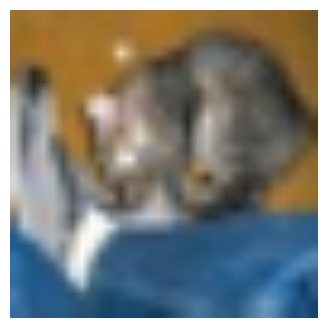

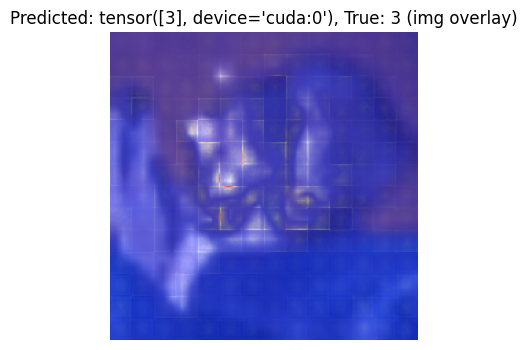

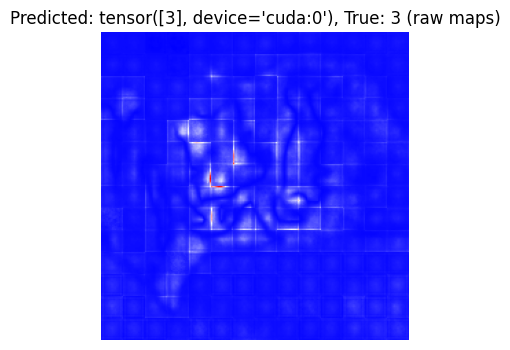

In [15]:
img_ind = 0
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
pred_idx = pred_idxs0[img_ind]
hmap = our_lrp_attrs[img_ind]
total_heatmap = hmap.sum(dim=1).squeeze(0)
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu().detach().numpy(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu().detach().numpy(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)


# Define MoRF/LeRF args

In [16]:
patch_size = 16
img_dims = 224
num_samples = 1000
num_patches = img_dims // patch_size
assert img_dims % patch_size == 0, f"Image dimensions {img_dims} must be divisible by patch_size {patch_size}"
occlusion_step = 4

default_args = {
    "model": vit_model,
    "patch_size": patch_size,
    "dims": img_dims,
    "occlusion_step": occlusion_step,
    "num_samples": num_samples,
    "baseline": [967, 33], # preds0,
    "eval_fcn": evaluateViT,
    "image_gen_fcn": get_imagenet_samples,
}

# Start MoRF/LeRF (scroll to bottom of outputs for metrics + curves)
Metrics are in following order: ABPC, Comprehensiveness, Sufficiency.

Comprehensiveness measures alignment of most relevant attributions, being the area between the baseline and the MoRF curve, so a curve that descends steeply and closer to the left produces a higher value, which is better.

Sufficiency measures alignment of least relevant attributions, being the area between the baseline and the LeRF curve. So a flatter curve with steep elbow further to the right produces a lower value, which is better.

In [17]:
from util import run_morf_lerf_occlusion_patches

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.95it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.87it/s]


1 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.22it/s]


2 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.95it/s]


3 [872, 128]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.92it/s]


4 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.38it/s]


5 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.20it/s]


6 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.48it/s]


7 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.04it/s]


8 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.91it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.83it/s]


10 [704, 296]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.74it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.37it/s]


12 [654, 346]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.68it/s]


13 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.85it/s]


14 [613, 387]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.08it/s]


15 [597, 403]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.71it/s]


16 [574, 426]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.64it/s]


17 [554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.59it/s]


18 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.26it/s]


19 [518, 482]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.78it/s]


20 [511, 489]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.29it/s]


21 [483, 517]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.30it/s]


22 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.75it/s]


23 [453, 547]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.91it/s]


24 [442, 558]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.30it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.74it/s]


26 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.78it/s]


27 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.19it/s]


28 [391, 609]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


29 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.75it/s]


30 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.06it/s]


31 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.77it/s]


32 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.08it/s]


33 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.23it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.50it/s]


35 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.97it/s]


36 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.58it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.96it/s]


38 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.88it/s]


39 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.63it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.80it/s]


41 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


42 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.95it/s]


43 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.15it/s]


44 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


45 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.07it/s]


46 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.01it/s]


47 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.20it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.73it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.03it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.89it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.70it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.62it/s]


4 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.91it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.78it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.12it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.40it/s]


8 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.69it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.94it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.49it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.44it/s]


12 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.67it/s]


13 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.66it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.08it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.58it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.08it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.88it/s]


18 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.34it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.92it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.86it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.10it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.79it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.87it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.76it/s]


26 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.21it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.82it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.91it/s]


29 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.03it/s]


30 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.62it/s]


31 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.13it/s]


32 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.01it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.20it/s]


34 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.66it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.83it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.55it/s]


37 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.11it/s]


38 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.71it/s]


39 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.31it/s]


40 [812, 188]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.46it/s]


41 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.70it/s]


42 [724, 276]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.16it/s]


43 [684, 316]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.25it/s]


44 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.96it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.61it/s]


46 [513, 487]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.69it/s]


47 [481, 519]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.33it/s]


48 [399, 601]


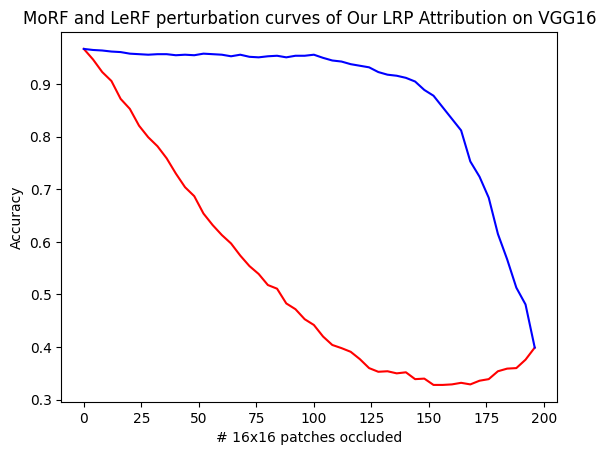

1.4447346938775507 1.7687346938775508 0.3240000000000001


In [18]:
# Ablating residuals results
morf_preds_ours, lerf_preds_ours, blurred_imgs = run_morf_lerf_occlusion_patches(heatmaps=our_lrp_attrs, attr_name="Our LRP", **default_args)
if "blurred_imgs" not in default_args:
    default_args["blurred_imgs"] = blurred_imgs

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.84it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.82it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.98it/s]


2 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.18it/s]


3 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.26it/s]


4 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.63it/s]


5 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.62it/s]


6 [804, 196]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.17it/s]


7 [777, 223]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.91it/s]


8 [752, 248]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.60it/s]


9 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


10 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.19it/s]


11 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.36it/s]


12 [644, 356]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.63it/s]


13 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.06it/s]


14 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.18it/s]


15 [592, 408]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.69it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.42it/s]


17 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.20it/s]


18 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.41it/s]


19 [505, 495]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.00it/s]


20 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.91it/s]


21 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.65it/s]


22 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.88it/s]


23 [439, 561]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.35it/s]


24 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.66it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.55it/s]


26 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.65it/s]


27 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.87it/s]


28 [366, 634]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.35it/s]


29 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.71it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.71it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.94it/s]


32 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.85it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.26it/s]


34 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.12it/s]


35 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.23it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.02it/s]


37 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.34it/s]


39 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.04it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.34it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


42 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.53it/s]


43 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.89it/s]


45 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.32it/s]


46 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.77it/s]


47 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.83it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.32it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.22it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.02it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.70it/s]


4 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.58it/s]


6 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.69it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.23it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.55it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.76it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.45it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.19it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.18it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.14it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


15 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.60it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.35it/s]


18 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.39it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.91it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.77it/s]


21 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.44it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.41it/s]


23 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.89it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.46it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.59it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.28it/s]


27 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.03it/s]


28 [942, 58]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.47it/s]


29 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.46it/s]


31 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.65it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.47it/s]


33 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.91it/s]


34 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.05it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.92it/s]


37 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.72it/s]


38 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.92it/s]


39 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.04it/s]


40 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.40it/s]


41 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.29it/s]


42 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.99it/s]


43 [693, 307]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.86it/s]


44 [633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


45 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.82it/s]


46 [515, 485]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.62it/s]


47 [480, 520]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.68it/s]

48 [399, 601]


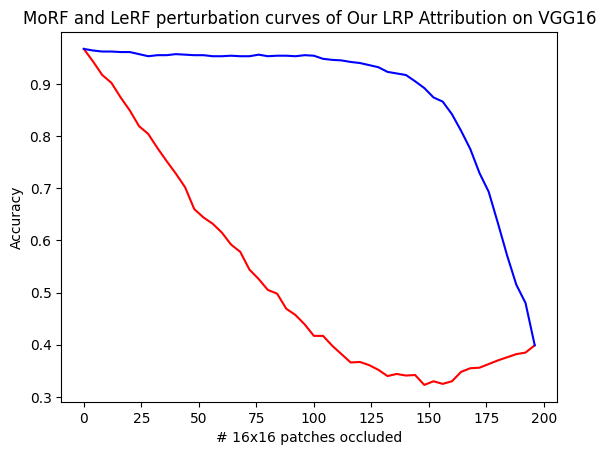

1.464163265306123 1.7799183673469383 0.31575510204081536


In [17]:
morf_preds_ours, lerf_preds_ours, blurred_imgs = run_morf_lerf_occlusion_patches(heatmaps=our_lrp_attrs, attr_name="Our LRP", **default_args)
if "blurred_imgs" not in default_args:
    default_args["blurred_imgs"] = blurred_imgs

# Compare against some saved attributions

In [14]:
# load external attributions
attnlrp_new_gamma_attrs = torch.load("../../external/LRP-eXplains-Transformers/zennit_lrp_attrs_conv100_lin0.001.pt").unsqueeze(1).unsqueeze(1) 

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.16it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]


1 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.62it/s]


3 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.86it/s]


4 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.63it/s]


5 [942, 58]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.33it/s]


6 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.30it/s]


7 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.35it/s]


8 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.60it/s]


9 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.30it/s]


10 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.89it/s]


11 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.63it/s]


12 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.90it/s]


13 [890, 110]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


14 [881, 119]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.08it/s]


15 [880, 120]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.96it/s]


16 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.62it/s]


17 [860, 140]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.66it/s]


18 [851, 149]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.21it/s]


19 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.99it/s]


20 [823, 177]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.85it/s]


21 [809, 191]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.76it/s]


22 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


23 [772, 228]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.88it/s]


24 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.04it/s]


25 [745, 255]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.70it/s]


26 [721, 279]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.67it/s]


27 [695, 305]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


28 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


29 [657, 343]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.62it/s]


30 [635, 365]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


31 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.41it/s]


32 [573, 427]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.90it/s]


33 [553, 447]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.95it/s]


34 [533, 467]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]


35 [512, 488]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


36 [481, 519]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.18it/s]


37 [466, 534]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.31it/s]


38 [449, 551]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.83it/s]


39 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.92it/s]


40 [433, 567]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.44it/s]


41 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.07it/s]


42 [412, 588]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.55it/s]


43 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.93it/s]


44 [394, 606]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.17it/s]


45 [384, 616]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.96it/s]


46 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.49it/s]


47 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.20it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.89it/s]


0 [967, 33]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.41it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.45it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.64it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.71it/s]


4 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.32it/s]


5 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.89it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


7 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.89it/s]


8 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.34it/s]


9 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.13it/s]


10 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


11 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.79it/s]


12 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.68it/s]


13 [942, 58]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.80it/s]


14 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.41it/s]


15 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.32it/s]


16 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.17it/s]


17 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.19it/s]


18 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.20it/s]


19 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.49it/s]


20 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.83it/s]


21 [880, 120]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


22 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.33it/s]


23 [852, 148]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.89it/s]


24 [831, 169]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.07it/s]


25 [811, 189]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.63it/s]


26 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


27 [780, 220]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.73it/s]


28 [749, 251]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.10it/s]


29 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.17it/s]


30 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.44it/s]


31 [676, 324]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.92it/s]


32 [657, 343]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.28it/s]


33 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.43it/s]


34 [603, 397]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.65it/s]


35 [580, 420]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.78it/s]


36 [557, 443]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.36it/s]


37 [521, 479]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.34it/s]


38 [490, 510]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.47it/s]


39 [460, 540]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.36it/s]


40 [438, 562]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.86it/s]


41 [425, 575]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.69it/s]


42 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.90it/s]


43 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.04it/s]


44 [401, 599]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.30it/s]


45 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.87it/s]


46 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.53it/s]


47 [401, 599]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.14it/s]


48 [399, 601]


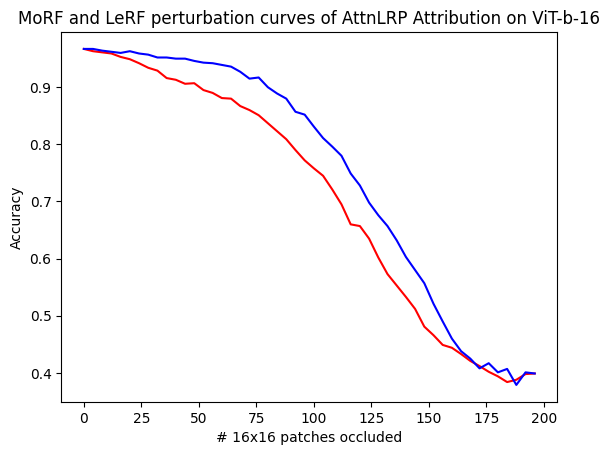

0.17314285714285674, 1.0283265306122444, 0.8551836734693877


In [16]:
morf_preds_attnlrp, lerf_preds_attnlrp, _ = run_morf_lerf_occlusion_patches(heatmaps=attnlrp_new_gamma_attrs, attr_name="AttnLRP", **default_args)

In [21]:
# load external attributions
attnlrp_attrs = torch.load("../../external/LRP-eXplains-Transformers/attnlrp_cifar10_attrs.pt").unsqueeze(1).unsqueeze(1)

In [22]:
attnlrp_attrs.shape

torch.Size([1000, 1, 1, 224, 224])

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.77it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.36it/s]


2 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.06it/s]


3 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


4 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.19it/s]


5 [829, 171]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.83it/s]


6 [808, 192]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.08it/s]


7 [780, 220]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.24it/s]


8 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.59it/s]


9 [739, 261]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.09it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


11 [674, 326]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.87it/s]


13 [643, 357]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.36it/s]


14 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.68it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.21it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.60it/s]


17 [553, 447]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


18 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


19 [519, 481]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.31it/s]


20 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


21 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.80it/s]


22 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


23 [438, 562]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.53it/s]


24 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.71it/s]


25 [392, 608]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


26 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.60it/s]


27 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.70it/s]


28 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.21it/s]


29 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.41it/s]


30 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.81it/s]


31 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.99it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.82it/s]


33 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.78it/s]


34 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.75it/s]


35 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.90it/s]


36 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.55it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.07it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.81it/s]


39 [331, 669]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.98it/s]


40 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


41 [319, 681]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.78it/s]


42 [324, 676]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.27it/s]


43 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


44 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.29it/s]


45 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.70it/s]


46 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


47 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.60it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


1 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.30it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.28it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.61it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.02it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.99it/s]


6 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.24it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.95it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.60it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.56it/s]


12 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


13 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.17it/s]


14 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.91it/s]


15 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.50it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.49it/s]


17 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.01it/s]


18 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.72it/s]


19 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


20 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


23 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.94it/s]


24 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.18it/s]


25 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


26 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.50it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.25it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


30 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.48it/s]


31 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.90it/s]


32 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.16it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


34 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


35 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.72it/s]


36 [893, 107]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


37 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.64it/s]


38 [862, 138]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.46it/s]


39 [835, 165]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.27it/s]


40 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.58it/s]


41 [772, 228]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


42 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.11it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.52it/s]


44 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


45 [568, 432]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.79it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


47 [458, 542]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]

48 [399, 601]


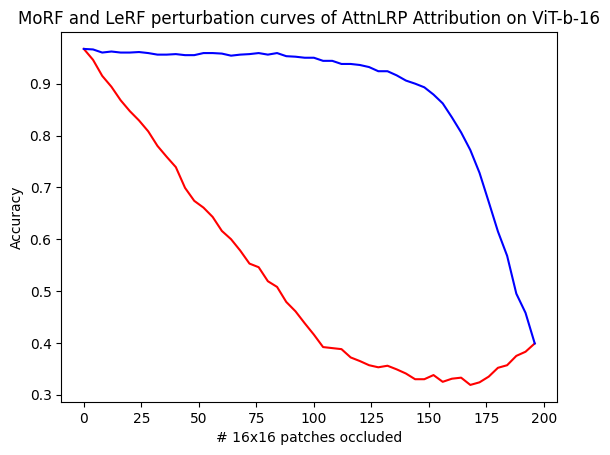

1.4565714285714282 1.781959183673469 0.3253877551020406


In [23]:
morf_preds_attnlrp, lerf_preds_attnlrp, _ = run_morf_lerf_occlusion_patches(heatmaps=attnlrp_attrs, attr_name="AttnLRP", **default_args)

In [32]:
# load external attributions
ig_attrs = torch.cat([ torch.load(f"../../../dynasliceBERT/captumsplitfinal/vit_captum_ig_checkpoint_{i}.pt") for i in range(1,11) ])

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.50it/s]


0 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.39it/s]


1 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.90it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.22it/s]


3 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.83it/s]


4 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


5 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.78it/s]


6 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.25it/s]


7 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.41it/s]


8 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.70it/s]


9 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.86it/s]


10 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


11 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.72it/s]


12 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.19it/s]


13 [901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.57it/s]


14 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.49it/s]


15 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.33it/s]


16 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.65it/s]


17 [863, 137]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.22it/s]


18 [862, 138]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.22it/s]


19 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.69it/s]


20 [838, 162]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


21 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


22 [809, 191]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.10it/s]


23 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.01it/s]


24 [785, 215]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.49it/s]


25 [763, 237]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.55it/s]


26 [750, 250]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.46it/s]


27 [742, 258]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.10it/s]


28 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.71it/s]


29 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.22it/s]


30 [682, 318]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.34it/s]


31 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.36it/s]


32 [627, 373]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.66it/s]


33 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.05it/s]


34 [587, 413]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.93it/s]


35 [564, 436]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.36it/s]


36 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


37 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


38 [475, 525]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.03it/s]


39 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.21it/s]


40 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


41 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.46it/s]


42 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


43 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


44 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.86it/s]


45 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.95it/s]


46 [405, 595]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.70it/s]


47 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.50it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.88it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.18it/s]


4 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.09it/s]


6 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


7 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.93it/s]


8 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.08it/s]


9 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.94it/s]


10 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.35it/s]


11 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.15it/s]


12 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


13 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


14 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]


15 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.98it/s]


16 [914, 86]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.02it/s]


17 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.95it/s]


18 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.36it/s]


19 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


20 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


21 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.14it/s]


22 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.48it/s]


23 [839, 161]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.89it/s]


24 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.41it/s]


25 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


26 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.96it/s]


27 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.89it/s]


28 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


29 [740, 260]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.63it/s]


30 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.50it/s]


31 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.23it/s]


32 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.66it/s]


33 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.30it/s]


34 [630, 370]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.99it/s]


35 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


36 [584, 416]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


37 [551, 449]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.68it/s]


38 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.58it/s]


39 [510, 490]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.45it/s]


40 [481, 519]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


41 [454, 546]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.25it/s]


42 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


43 [433, 567]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


44 [409, 591]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.30it/s]


45 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.39it/s]


46 [405, 595]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.03it/s]


47 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.58it/s]

48 [399, 601]


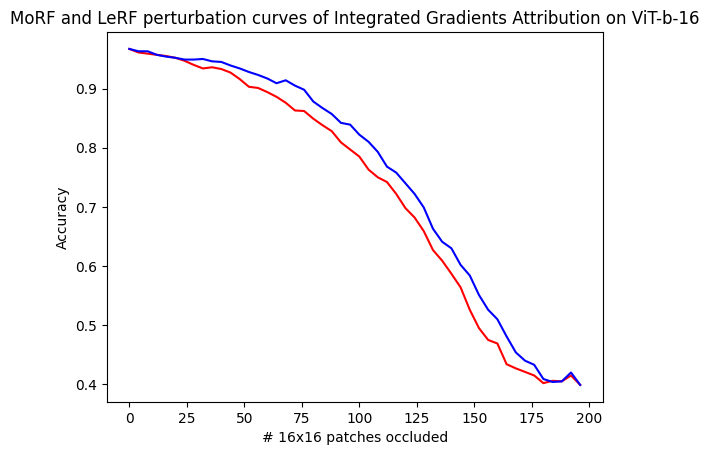

0.1013877551020406 0.946857142857142 0.8454693877551014


In [35]:
morf_preds_ig, lerf_preds_ig, _ = run_morf_lerf_occlusion_patches(heatmaps=ig_attrs, attr_name="Integrated Gradients", **default_args)

In [45]:
shap_attrs = torch.cat([ torch.load(f"../../../dynasliceBERT/captumsplitfinal/vit_captum_shap_checkpoint_{i}.pt") for i in range(1,11) ])

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.66it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.52it/s]


1 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.25it/s]


2 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.99it/s]


3 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.28it/s]


4 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.00it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.68it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.65it/s]


7 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.17it/s]


8 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.64it/s]


9 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


10 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.67it/s]


11 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


12 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.91it/s]


13 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.60it/s]


14 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


15 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.52it/s]


16 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.42it/s]


17 [871, 129]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.93it/s]


18 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.68it/s]


19 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


20 [839, 161]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.35it/s]


21 [831, 169]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.52it/s]


22 [809, 191]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


23 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.95it/s]


24 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.05it/s]


25 [760, 240]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.95it/s]


26 [747, 253]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


27 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.75it/s]


28 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.76it/s]


29 [690, 310]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.62it/s]


30 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


31 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.80it/s]


32 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.32it/s]


33 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


34 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.63it/s]


35 [550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.69it/s]


36 [536, 464]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.73it/s]


37 [509, 491]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.86it/s]


38 [491, 509]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.67it/s]


39 [470, 530]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.11it/s]


40 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]


41 [441, 559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


42 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.98it/s]


43 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.71it/s]


44 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


45 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


46 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


47 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.06it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.48it/s]


0 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.16it/s]


1 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.70it/s]


2 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.62it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.78it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.07it/s]


6 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.57it/s]


7 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.49it/s]


8 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.74it/s]


9 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.72it/s]


10 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.66it/s]


11 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.40it/s]


12 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.06it/s]


13 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


14 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.23it/s]


15 [910, 90]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.93it/s]


16 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


17 [893, 107]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.24it/s]


18 [887, 113]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.08it/s]


19 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.10it/s]


20 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.54it/s]


21 [855, 145]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.61it/s]


22 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.79it/s]


23 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


24 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.32it/s]


25 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


26 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


27 [776, 224]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.44it/s]


28 [756, 244]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.61it/s]


29 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.84it/s]


30 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


31 [685, 315]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.80it/s]


32 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.58it/s]


33 [635, 365]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.32it/s]


34 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.68it/s]


35 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


36 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.94it/s]


37 [524, 476]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.12it/s]


38 [515, 485]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.17it/s]


39 [489, 511]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.33it/s]


40 [463, 537]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.73it/s]


41 [446, 554]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.16it/s]


42 [437, 563]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.93it/s]


43 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.28it/s]


44 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.55it/s]


45 [410, 590]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.07it/s]


46 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.50it/s]


47 [397, 603]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.75it/s]

48 [399, 601]


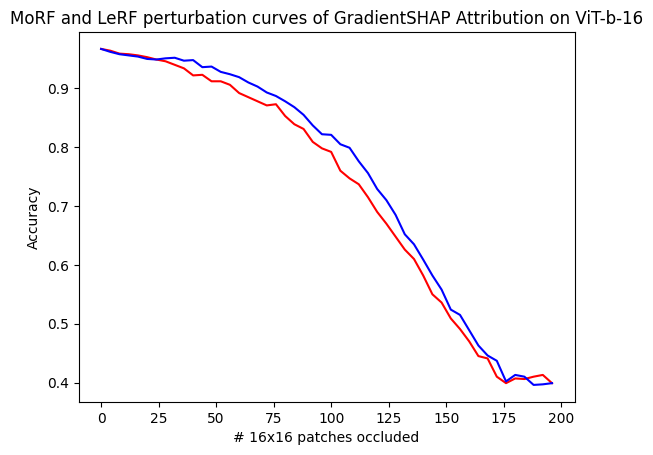

0.07395918367346987 0.944734693877551 0.8707755102040812


In [46]:
morf_preds_shap, lerf_preds_shap, _ = run_morf_lerf_occlusion_patches(shap_attrs, attr_name="GradientSHAP", **default_args)

In [25]:
ixg_attrs = torch.load("../../../dynasliceBERT/captumsplitfinal/vit_captum_inputxgrad_checkpoint_1.pt")

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.18it/s]


0 [967, 33]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.69it/s]


1 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.42it/s]


2 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


3 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.11it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.65it/s]


5 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.22it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


7 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.31it/s]


8 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.20it/s]


9 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.24it/s]


10 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.74it/s]


11 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


12 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.65it/s]


13 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.38it/s]


14 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.29it/s]


15 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.41it/s]


16 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.40it/s]


17 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.35it/s]


18 [881, 119]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


19 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


20 [844, 156]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


21 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


22 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.95it/s]


23 [803, 197]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.08it/s]


24 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.66it/s]


25 [772, 228]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.24it/s]


26 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.04it/s]


27 [741, 259]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.33it/s]


28 [736, 264]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.13it/s]


29 [709, 291]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


30 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.91it/s]


31 [678, 322]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.97it/s]


32 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.28it/s]


33 [629, 371]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.59it/s]


34 [592, 408]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.15it/s]


35 [577, 423]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


36 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.04it/s]


37 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


38 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


39 [493, 507]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


40 [462, 538]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.83it/s]


41 [451, 549]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.86it/s]


42 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.36it/s]


43 [430, 570]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.37it/s]


44 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.06it/s]


45 [426, 574]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.12it/s]


46 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.06it/s]


47 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.65it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.18it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.78it/s]


2 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.14it/s]


3 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


4 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


5 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


6 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.50it/s]


7 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


8 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.33it/s]


9 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


10 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.76it/s]


11 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.34it/s]


12 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.46it/s]


13 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


14 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.02it/s]


15 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.79it/s]


16 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.61it/s]


17 [888, 112]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.41it/s]


18 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


19 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.07it/s]


20 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.94it/s]


21 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.31it/s]


22 [840, 160]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


23 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.99it/s]


24 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.72it/s]


25 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.23it/s]


26 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


27 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.51it/s]


28 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


29 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.26it/s]


30 [682, 318]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.63it/s]


31 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.09it/s]


32 [640, 360]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


33 [617, 383]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


34 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


35 [572, 428]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


36 [552, 448]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.67it/s]


37 [529, 471]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


38 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.21it/s]


39 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


40 [460, 540]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


41 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.24it/s]


42 [438, 562]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


43 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.64it/s]


44 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


45 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.23it/s]


46 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.83it/s]


47 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.44it/s]

48 [399, 601]


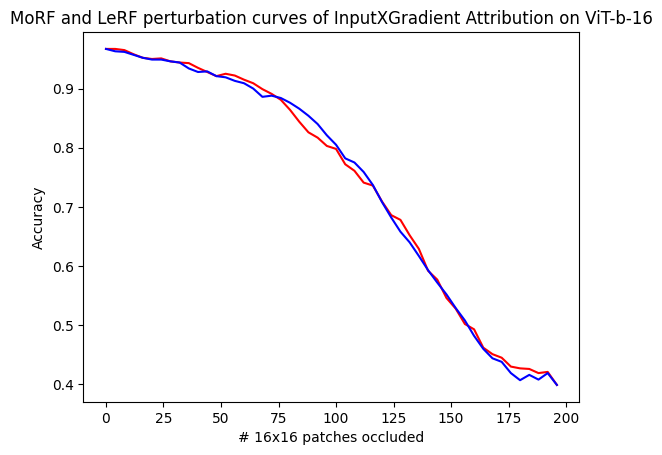

-0.003020408163264647 0.8949387755102042 0.8979591836734688


In [30]:
morf_preds_ixg, lerf_preds_ixg, _ = run_morf_lerf_occlusion_patches(heatmaps=ixg_attrs, attr_name="InputXGradient", **default_args)

In [43]:
random_attrs = torch.rand((1000, 1, 3, 224, 224), device=device)

Running 49 occlusion iterations with 16x16 patches
Computing baseline...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.91it/s]


Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.25it/s]


0 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.02it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.09it/s]


2 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


3 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.04it/s]


4 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


5 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.51it/s]


6 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.16it/s]


7 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.31it/s]


8 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.85it/s]


9 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.77it/s]


10 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.32it/s]


11 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.20it/s]


12 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


13 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.50it/s]


14 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


15 [914, 86]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.31it/s]


16 [908, 92]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.78it/s]


17 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.33it/s]


18 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.57it/s]


19 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


20 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.97it/s]


21 [848, 152]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


22 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


23 [816, 184]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.33it/s]


24 [803, 197]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.90it/s]


25 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.87it/s]


26 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.00it/s]


27 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.05it/s]


28 [735, 265]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.47it/s]


29 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.70it/s]


30 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.39it/s]


31 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


32 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.24it/s]


33 [623, 377]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


34 [595, 405]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


35 [569, 431]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.64it/s]


36 [554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.68it/s]


37 [533, 467]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.16it/s]


38 [507, 493]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.48it/s]


39 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.52it/s]


40 [464, 536]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.00it/s]


41 [452, 548]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


42 [454, 546]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.38it/s]


43 [425, 575]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.32it/s]


44 [416, 584]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


45 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.63it/s]


46 [428, 572]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.77it/s]


47 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.63it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.38it/s]


0 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.22it/s]


2 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.17it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.84it/s]


4 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.88it/s]


5 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.50it/s]


6 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.14it/s]


7 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


8 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.84it/s]


9 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.30it/s]


10 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


11 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.45it/s]


12 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.38it/s]


13 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.08it/s]


14 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


15 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.84it/s]


16 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.76it/s]


17 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.05it/s]


18 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.72it/s]


19 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


20 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.40it/s]


21 [840, 160]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.38it/s]


22 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.07it/s]


23 [807, 193]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.33it/s]


24 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.20it/s]


25 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.01it/s]


26 [756, 244]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.41it/s]


27 [735, 265]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.58it/s]


28 [719, 281]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.70it/s]


29 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.73it/s]


30 [676, 324]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


31 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.37it/s]


32 [613, 387]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.96it/s]


33 [606, 394]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.55it/s]


34 [588, 412]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.87it/s]


35 [561, 439]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.04it/s]


36 [542, 458]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


37 [509, 491]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.39it/s]


38 [499, 501]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.58it/s]


39 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


40 [459, 541]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.19it/s]


41 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.79it/s]


42 [423, 577]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.32it/s]


43 [431, 569]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.92it/s]


44 [435, 565]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.53it/s]


45 [412, 588]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.02it/s]


46 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.57it/s]


47 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]

48 [399, 601]


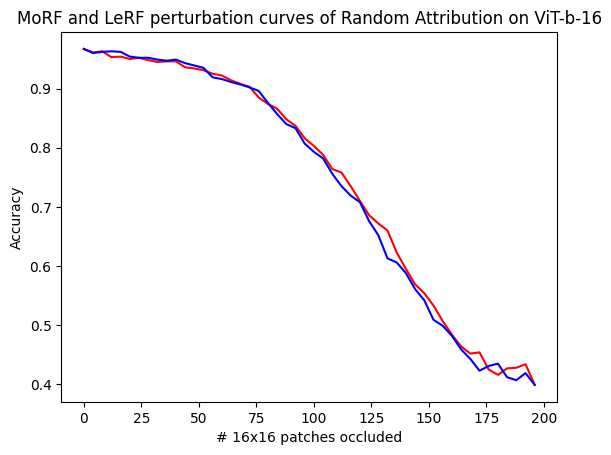

-0.02261224489795985 0.8768979591836726 0.8995102040816325


In [44]:
morf_preds_random, lerf_preds_random, _ = run_morf_lerf_occlusion_patches(heatmaps=random_attrs, attr_name="Random", **default_args)

# Old cells (do not run, purely for documentation purposes)

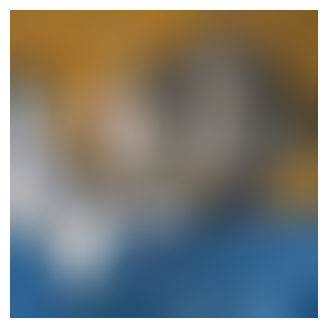

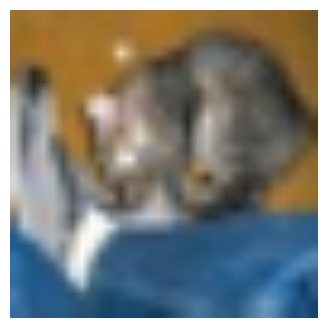

In [18]:
blurred = blurred_imgs[0]
plot_img(blurred)
plot_img(imgs_list[0])

# Gamma hyperparameter search

In [15]:
# Generate our attributions
gamma_vals = [(130, 0.01), (130, 0.001), (125, 0.1), (130, 0.3), (150, 0.01), (125, 0.001)]
for conv_gamma, mm_gamma in gamma_vals:
    lrp_engine.conv_gamma = conv_gamma
    lrp_engine.mm_gamma = mm_gamma
    preds0, pred_idxs0, our_lrp_attrs = evaluateViT(vit_model, imgs_list, labels_list, engine=lrp_engine, run_lrp=True)
    torch.save(our_lrp_attrs, f"ourlrp_withattn_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.94it/s]


Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.77it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.04it/s]


1 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.33it/s]


2 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.73it/s]


3 [872, 128]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.04it/s]


4 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.01it/s]


5 [825, 175]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.89it/s]


6 [808, 192]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.06it/s]


7 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.19it/s]


8 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.15it/s]


9 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.58it/s]


11 [667, 333]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.49it/s]


12 [643, 357]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.14it/s]


13 [633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


14 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.67it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.83it/s]


16 [581, 419]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


17 [557, 443]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.10it/s]


18 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.99it/s]


19 [529, 471]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.34it/s]


20 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.88it/s]


21 [462, 538]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


22 [453, 547]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.87it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.27it/s]


24 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.45it/s]


25 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.48it/s]


26 [392, 608]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.09it/s]


27 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.09it/s]


28 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.88it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.79it/s]


30 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


31 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


32 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.99it/s]


33 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.86it/s]


34 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.96it/s]


35 [327, 673]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.77it/s]


36 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.51it/s]


37 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.77it/s]


38 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.87it/s]


40 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.05it/s]


41 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.00it/s]


42 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.48it/s]


43 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.66it/s]


44 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.77it/s]


45 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.67it/s]


46 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.55it/s]


47 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.86it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.97it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.33it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.00it/s]


2 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.13it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.31it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.93it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.32it/s]


6 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.70it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.39it/s]


8 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.65it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.84it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.14it/s]


11 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.83it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.67it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.83it/s]


14 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.46it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.32it/s]


16 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.03it/s]


17 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.62it/s]


18 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.78it/s]


19 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


20 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.08it/s]


23 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.34it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.82it/s]


25 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.22it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.01it/s]


27 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.27it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.47it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.10it/s]


32 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.28it/s]


33 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.85it/s]


34 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.63it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.49it/s]


36 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.61it/s]


37 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.14it/s]


38 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.90it/s]


39 [841, 159]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


40 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


41 [769, 231]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.61it/s]


42 [732, 268]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.32it/s]


43 [685, 315]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.61it/s]


44 [634, 366]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.94it/s]


45 [570, 430]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.40it/s]


46 [513, 487]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.02it/s]


47 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.46it/s]

48 [399, 601]


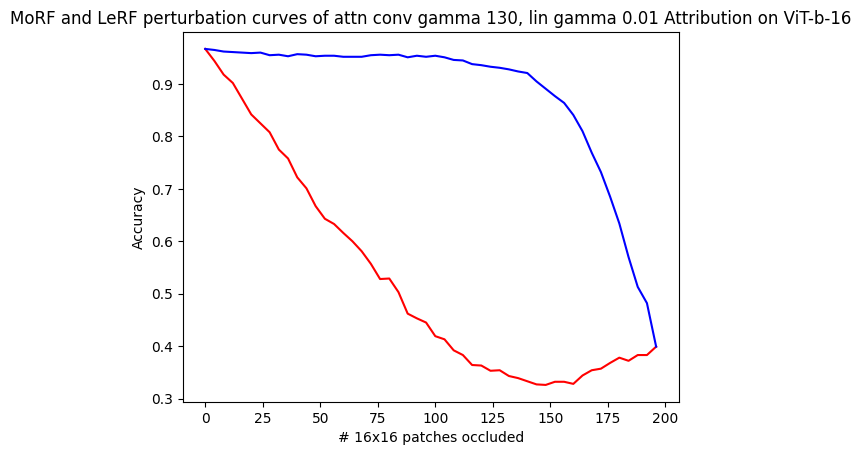

1.4608979591836735, 1.777632653061224, 0.31673469387755065
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.24it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.09it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.61it/s]


2 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.20it/s]


3 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.73it/s]


4 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.90it/s]


5 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.82it/s]


6 [804, 196]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.69it/s]


7 [777, 223]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.50it/s]


8 [752, 248]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.04it/s]


9 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


10 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.92it/s]


11 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.44it/s]


12 [645, 355]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.69it/s]


13 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.46it/s]


14 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.51it/s]


15 [592, 408]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.04it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]


17 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.07it/s]


18 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.08it/s]


19 [505, 495]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


20 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.10it/s]


21 [468, 532]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.80it/s]


22 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.71it/s]


23 [439, 561]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.85it/s]


24 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.88it/s]


25 [418, 582]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


26 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.29it/s]


27 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


28 [366, 634]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.79it/s]


29 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.37it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.85it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


32 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.25it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.60it/s]


34 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.36it/s]


35 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.36it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.45it/s]


37 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.01it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.47it/s]


39 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.92it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.41it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.37it/s]


42 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.07it/s]


43 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.29it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.37it/s]


45 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.09it/s]


46 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.92it/s]


47 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.83it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.89it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.43it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.69it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.93it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.56it/s]


4 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.05it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.41it/s]


6 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.72it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.87it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.35it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.12it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.00it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.99it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.45it/s]


15 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.96it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.75it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.73it/s]


18 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.37it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.26it/s]


21 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.52it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.25it/s]


23 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.65it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.01it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.96it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.61it/s]


27 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.92it/s]


28 [942, 58]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.03it/s]


29 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.23it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.19it/s]


31 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.77it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.39it/s]


33 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.37it/s]


34 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.97it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.61it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


37 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


38 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.25it/s]


39 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.82it/s]


40 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.07it/s]


41 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.36it/s]


42 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.42it/s]


43 [693, 307]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


44 [633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.25it/s]


45 [570, 430]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.28it/s]


46 [515, 485]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.21it/s]


47 [480, 520]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]

48 [399, 601]


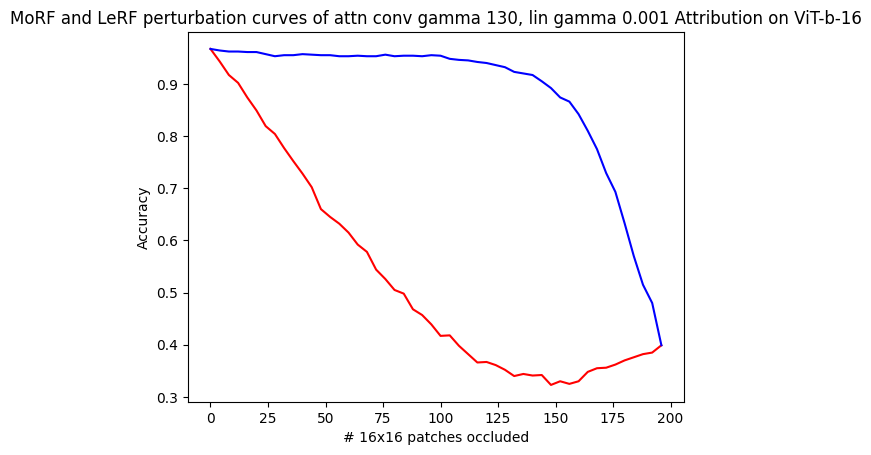

1.4640816326530617, 1.7799183673469388, 0.31583673469387696
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.43it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.84it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.20it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.58it/s]


3 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.11it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.96it/s]


5 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.89it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.66it/s]


7 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.12it/s]


8 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.39it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.30it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.34it/s]


11 [673, 327]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.04it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.91it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.68it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.57it/s]


16 [573, 427]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


17 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.54it/s]


18 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.57it/s]


19 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.81it/s]


20 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.80it/s]


21 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.34it/s]


22 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


23 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.50it/s]


24 [429, 571]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.98it/s]


25 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.60it/s]


26 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.87it/s]


27 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.28it/s]


28 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.30it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.33it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.51it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.70it/s]


32 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.83it/s]


33 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.73it/s]


34 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.75it/s]


36 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.12it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.02it/s]


38 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.85it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


40 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.23it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.56it/s]


42 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.40it/s]


43 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.62it/s]


44 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.93it/s]


45 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.70it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.03it/s]


47 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.63it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.32it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.27it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.19it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.67it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.15it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.28it/s]


5 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.97it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.38it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.80it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.78it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.56it/s]


10 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.14it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.66it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.85it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.85it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.92it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.40it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


18 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.30it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.22it/s]


20 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.75it/s]


21 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


22 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.86it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.30it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.50it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.67it/s]


26 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.63it/s]


27 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.42it/s]


28 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.69it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.38it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


32 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.17it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.30it/s]


34 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.80it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.37it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


37 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.77it/s]


38 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.13it/s]


39 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.57it/s]


40 [794, 206]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.17it/s]


42 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.28it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.72it/s]


44 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.28it/s]


45 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.58it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.65it/s]


47 [477, 523]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.16it/s]

48 [399, 601]


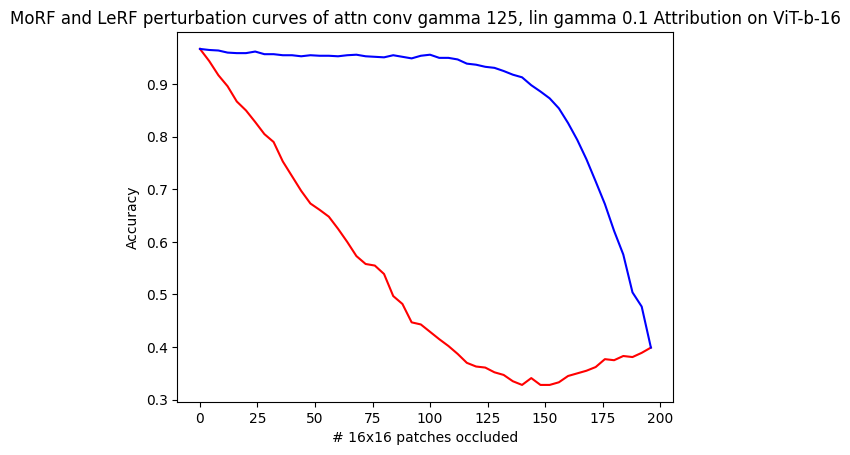

1.4352653061224496, 1.7625306122448974, 0.32726530612244786
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.25it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.39it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.27it/s]


2 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.97it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.81it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


5 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.49it/s]


6 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.22it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.24it/s]


8 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.70it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.43it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.28it/s]


11 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.18it/s]


12 [655, 345]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.73it/s]


13 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.45it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.36it/s]


15 [599, 401]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.15it/s]


16 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.27it/s]


17 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.46it/s]


18 [548, 452]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.57it/s]


19 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.07it/s]


20 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.33it/s]


21 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.08it/s]


22 [467, 533]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.76it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.80it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.94it/s]


26 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


27 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.50it/s]


28 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.83it/s]


29 [374, 626]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.81it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.66it/s]


31 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.80it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.25it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.23it/s]


34 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.60it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.05it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.04it/s]


38 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.50it/s]


39 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.72it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.74it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.97it/s]


42 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


43 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.06it/s]


44 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.79it/s]


45 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.97it/s]


46 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.22it/s]


47 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.43it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.53it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.86it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.28it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.86it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.02it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.39it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.64it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.37it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.83it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.02it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.29it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.80it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.86it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.05it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


17 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.44it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.75it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.11it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.17it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.98it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.35it/s]


25 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.09it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.07it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.84it/s]


28 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.86it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.85it/s]


30 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.85it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


32 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.02it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.81it/s]


35 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


37 [869, 131]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.72it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.92it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.64it/s]


40 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


41 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.83it/s]


42 [716, 284]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.71it/s]


43 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.52it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.77it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.83it/s]


47 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.34it/s]


48 [399, 601]


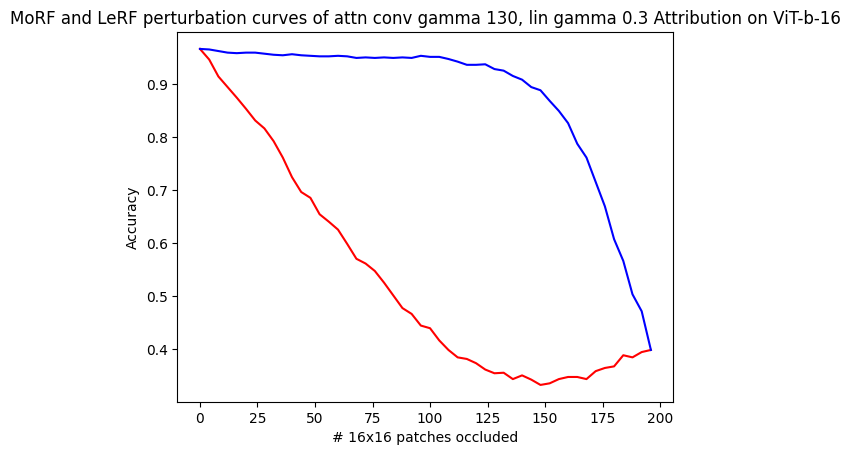

1.4193469387755098, 1.751836734693877, 0.33248979591836736
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.35it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.56it/s]


1 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.14it/s]


2 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.81it/s]


3 [872, 128]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.17it/s]


4 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.92it/s]


5 [825, 175]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.63it/s]


6 [808, 192]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.19it/s]


7 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.86it/s]


8 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.94it/s]


9 [722, 278]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.11it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.04it/s]


11 [667, 333]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.85it/s]


12 [643, 357]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.32it/s]


13 [633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.16it/s]


14 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


15 [601, 399]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.60it/s]


16 [581, 419]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.70it/s]


17 [557, 443]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


18 [527, 473]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.39it/s]


19 [527, 473]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.84it/s]


20 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.37it/s]


21 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.81it/s]


22 [453, 547]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.01it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.18it/s]


24 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.34it/s]


25 [412, 588]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.15it/s]


26 [392, 608]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.56it/s]


27 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.59it/s]


28 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.03it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.87it/s]


30 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.32it/s]


31 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.45it/s]


32 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.24it/s]


33 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.99it/s]


34 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.66it/s]


35 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.18it/s]


36 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.68it/s]


37 [331, 669]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.10it/s]


38 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.25it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.92it/s]


40 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.41it/s]


41 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.27it/s]


42 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.01it/s]


43 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.89it/s]


44 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.97it/s]


45 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.49it/s]


46 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]


47 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.19it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.03it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.25it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.51it/s]


2 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.53it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.05it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.23it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.77it/s]


6 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.95it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.28it/s]


8 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.90it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.26it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.12it/s]


11 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.37it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.86it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]


14 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.94it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.76it/s]


17 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.15it/s]


18 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.50it/s]


19 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


20 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.13it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.95it/s]


23 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.33it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.75it/s]


25 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.01it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.85it/s]


27 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.52it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.78it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.09it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.37it/s]


32 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


33 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


34 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


36 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.64it/s]


37 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.07it/s]


38 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.09it/s]


39 [841, 159]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.82it/s]


40 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


41 [769, 231]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


42 [732, 268]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.23it/s]


43 [685, 315]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.36it/s]


44 [634, 366]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.14it/s]


45 [570, 430]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


46 [513, 487]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.30it/s]


47 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.94it/s]

48 [399, 601]


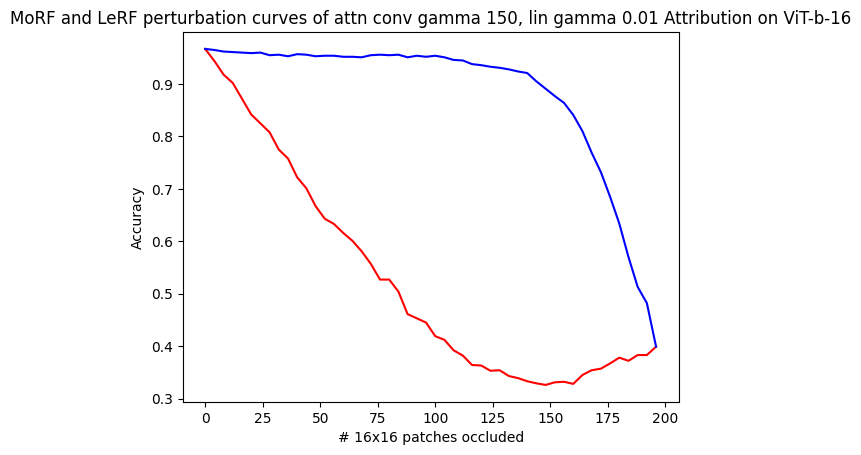

1.4610612244897956, 1.777877551020408, 0.31681632653061226
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.20it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.83it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.63it/s]


2 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.31it/s]


3 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.24it/s]


4 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.48it/s]


5 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.07it/s]


6 [804, 196]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.58it/s]


7 [777, 223]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.25it/s]


8 [752, 248]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.15it/s]


9 [728, 272]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.39it/s]


10 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.19it/s]


11 [660, 340]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.45it/s]


12 [644, 356]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.02it/s]


13 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.71it/s]


14 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.72it/s]


15 [592, 408]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.95it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.47it/s]


17 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.09it/s]


18 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.68it/s]


19 [505, 495]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.53it/s]


20 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.51it/s]


21 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.81it/s]


22 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.56it/s]


23 [439, 561]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.89it/s]


24 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.77it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.55it/s]


26 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


27 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.60it/s]


28 [366, 634]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.32it/s]


29 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.79it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.41it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.85it/s]


32 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.16it/s]


34 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.32it/s]


35 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.89it/s]


37 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.77it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.55it/s]


39 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.31it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.65it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


42 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.89it/s]


43 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.08it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.18it/s]


45 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.11it/s]


46 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.83it/s]


47 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.82it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.91it/s]


0 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.70it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.10it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.18it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.03it/s]


4 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.93it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.64it/s]


6 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.05it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.01it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.03it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.91it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.77it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.81it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.96it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.57it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.07it/s]


15 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.18it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.95it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.89it/s]


18 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.61it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.58it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.20it/s]


21 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.31it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


23 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.02it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.86it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.38it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.84it/s]


27 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.17it/s]


28 [942, 58]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.54it/s]


29 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.56it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.71it/s]


31 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.83it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.31it/s]


33 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.66it/s]


34 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.15it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.56it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.52it/s]


37 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.18it/s]


38 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.52it/s]


39 [842, 158]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


40 [810, 190]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.08it/s]


41 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.50it/s]


42 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.23it/s]


43 [693, 307]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.60it/s]


44 [633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.99it/s]


45 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.46it/s]


46 [515, 485]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.20it/s]


47 [480, 520]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.05it/s]

48 [399, 601]


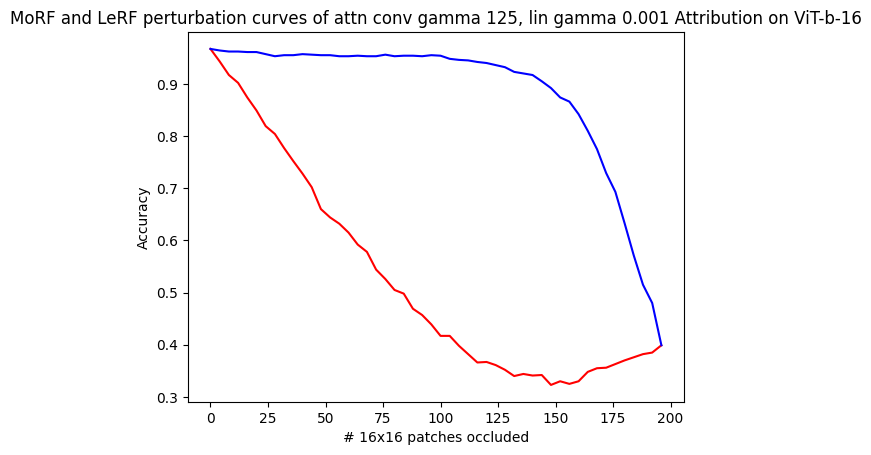

1.464163265306123, 1.7799183673469383, 0.31575510204081536


In [18]:
for conv_gamma, mm_gamma in gamma_vals:
    attrs = torch.load(f"ourlrp_withattn_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")
    _, _, blurred_imgs = run_morf_lerf_occlusion(heatmaps=attrs, attr_name=f"attn conv gamma {conv_gamma}, lin gamma {mm_gamma}", **default_args)
    if "blurred_imgs" not in default_args:
        default_args["blurred_imgs"] = blurred_imgs

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.18it/s]


0 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.70it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.20it/s]


2 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.01it/s]


3 [870, 130]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.36it/s]


4 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


5 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.97it/s]


6 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.97it/s]


7 [781, 219]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.07it/s]


8 [755, 245]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.56it/s]


9 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.10it/s]


10 [706, 294]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.39it/s]


11 [677, 323]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.87it/s]


12 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.21it/s]


13 [636, 364]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.00it/s]


14 [619, 381]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.99it/s]


15 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.96it/s]


16 [579, 421]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.59it/s]


17 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.45it/s]


18 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.81it/s]


19 [521, 479]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.85it/s]


20 [506, 494]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.89it/s]


21 [485, 515]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.82it/s]


22 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.08it/s]


23 [452, 548]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.89it/s]


24 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.82it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.32it/s]


26 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


27 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.16it/s]


28 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.54it/s]


29 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.58it/s]


30 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


31 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.63it/s]


32 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.00it/s]


33 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.52it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.28it/s]


36 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.52it/s]


38 [324, 676]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.65it/s]


39 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.99it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.59it/s]


41 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


42 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.49it/s]


43 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.20it/s]


45 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.42it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.11it/s]


47 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.65it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.61it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.82it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.80it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.66it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.08it/s]


4 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


5 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.10it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.82it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.75it/s]


8 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.36it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.90it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.47it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.83it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.54it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.03it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.48it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.78it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.76it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.96it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.25it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.54it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.74it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


26 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.29it/s]


28 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.20it/s]


29 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.97it/s]


30 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


31 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.35it/s]


32 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.97it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.23it/s]


34 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.95it/s]


35 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.68it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.36it/s]


37 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.71it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.23it/s]


39 [830, 170]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.95it/s]


40 [811, 189]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


42 [719, 281]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.35it/s]


43 [679, 321]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.04it/s]


44 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


45 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.95it/s]


46 [501, 499]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.25it/s]


47 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.57it/s]


48 [399, 601]


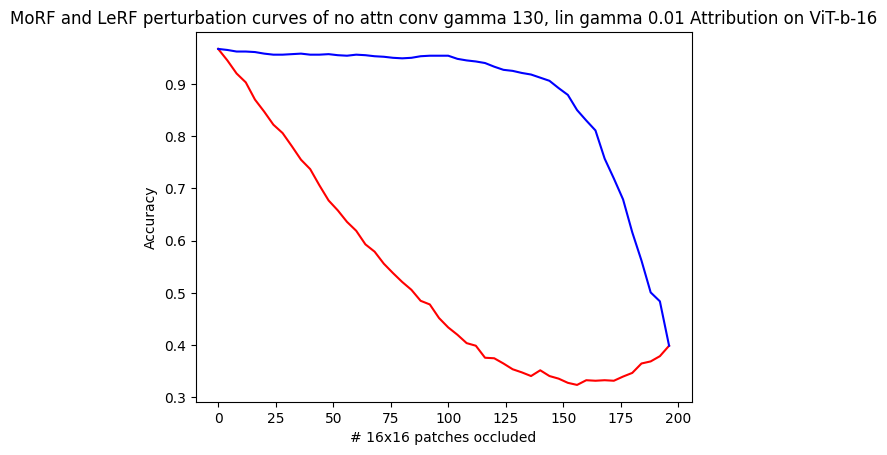

1.4427755102040813, 1.7700408163265302, 0.32726530612244903
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.01it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.28it/s]


1 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.87it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.36it/s]


3 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.98it/s]


4 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.47it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.73it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.97it/s]


7 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.17it/s]


8 [776, 224]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.00it/s]


9 [738, 262]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.65it/s]


10 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.65it/s]


11 [693, 307]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


12 [680, 320]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.11it/s]


13 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.24it/s]


14 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.62it/s]


15 [623, 377]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.11it/s]


16 [598, 402]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.18it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.23it/s]


18 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.29it/s]


19 [552, 448]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.28it/s]


20 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.51it/s]


21 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.64it/s]


22 [486, 514]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.83it/s]


23 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


24 [449, 551]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.50it/s]


25 [448, 552]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.40it/s]


26 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


27 [414, 586]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.00it/s]


28 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.51it/s]


29 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.81it/s]


30 [373, 627]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.25it/s]


31 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.66it/s]


32 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.22it/s]


33 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.45it/s]


34 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.44it/s]


36 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.82it/s]


37 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.76it/s]


38 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.98it/s]


39 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.74it/s]


40 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.23it/s]


41 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.56it/s]


42 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.54it/s]


43 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.71it/s]


44 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


45 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.44it/s]


46 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.37it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.17it/s]


2 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.50it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.00it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.39it/s]


7 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.90it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.74it/s]


9 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.36it/s]


11 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.42it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.67it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.67it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.33it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.74it/s]


16 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.84it/s]


17 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.56it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.64it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.87it/s]


20 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.01it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.68it/s]


22 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.72it/s]


23 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.10it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.27it/s]


25 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


26 [941, 59]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


27 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.93it/s]


28 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.67it/s]


29 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.20it/s]


30 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.76it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.78it/s]


32 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.21it/s]


33 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.14it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.93it/s]


35 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.88it/s]


36 [881, 119]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.63it/s]


37 [865, 135]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.99it/s]


38 [841, 159]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.74it/s]


39 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.44it/s]


40 [785, 215]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.04it/s]


41 [746, 254]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.57it/s]


42 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.89it/s]


44 [607, 393]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.42it/s]


45 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.70it/s]


46 [485, 515]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.59it/s]


47 [463, 537]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.43it/s]


48 [399, 601]


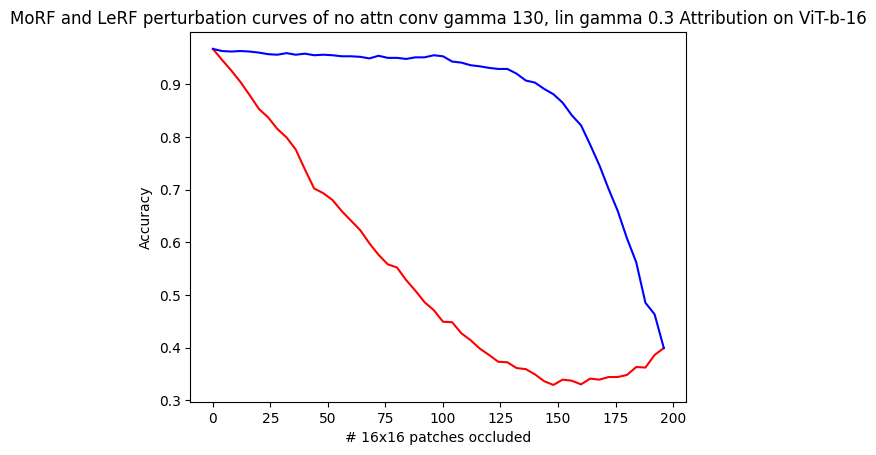

1.377959183673469, 1.7239183673469383, 0.34595918367346934
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.63it/s]


0 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.20it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.14it/s]


2 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.86it/s]


3 [870, 130]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.58it/s]


4 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


5 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.32it/s]


6 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.11it/s]


7 [781, 219]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


8 [755, 245]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.67it/s]


9 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.97it/s]


10 [706, 294]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.65it/s]


11 [677, 323]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.66it/s]


12 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.39it/s]


13 [636, 364]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.59it/s]


14 [619, 381]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


15 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]


16 [579, 421]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.22it/s]


17 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.15it/s]


18 [537, 463]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.68it/s]


19 [521, 479]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.93it/s]


20 [506, 494]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


21 [486, 514]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.31it/s]


22 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


23 [452, 548]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


24 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.64it/s]


26 [405, 595]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.08it/s]


27 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.20it/s]


28 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


29 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.91it/s]


30 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.40it/s]


31 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.74it/s]


32 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.84it/s]


33 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.89it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.25it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


36 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.01it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.52it/s]


39 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.00it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.26it/s]


41 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.87it/s]


42 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.41it/s]


43 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.59it/s]


44 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.14it/s]


45 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.99it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.43it/s]


47 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.19it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.61it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.38it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.21it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.61it/s]


4 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


5 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.96it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.69it/s]


8 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.26it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.28it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.21it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.97it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.35it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.39it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.55it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.41it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.98it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.13it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.00it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.05it/s]


26 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.45it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.23it/s]


28 [941, 59]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.18it/s]


29 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.23it/s]


30 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.17it/s]


32 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.83it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


34 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.50it/s]


35 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.61it/s]


37 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.86it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.36it/s]


39 [830, 170]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.85it/s]


40 [811, 189]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.88it/s]


41 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.13it/s]


42 [719, 281]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.27it/s]


43 [679, 321]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.47it/s]


44 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


45 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


46 [501, 499]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.54it/s]


47 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.01it/s]


48 [399, 601]


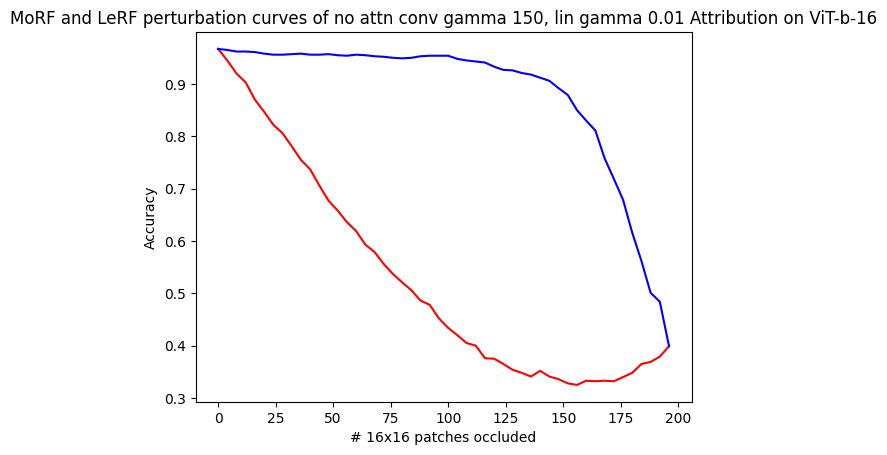

1.44269387755102, 1.7697142857142854, 0.32702040816326533
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.59it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.21it/s]


1 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.33it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.49it/s]


3 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.41it/s]


4 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.40it/s]


6 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.20it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.86it/s]


8 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.94it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


10 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.02it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.10it/s]


12 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.08it/s]


13 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.59it/s]


14 [638, 362]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.84it/s]


15 [612, 388]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.93it/s]


16 [591, 409]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.68it/s]


17 [577, 423]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.56it/s]


18 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


19 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.78it/s]


20 [520, 480]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.58it/s]


21 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.47it/s]


22 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


23 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.28it/s]


24 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.82it/s]


25 [436, 564]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.61it/s]


26 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.85it/s]


27 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.14it/s]


28 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.12it/s]


29 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.44it/s]


30 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.28it/s]


31 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.57it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.10it/s]


33 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.32it/s]


34 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.77it/s]


35 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.97it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.17it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


38 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.73it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.25it/s]


40 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


41 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


42 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.88it/s]


43 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.53it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.40it/s]


45 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.50it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.96it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.75it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.31it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.33it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.05it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.36it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.00it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.96it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.81it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.19it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.38it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.30it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.67it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.85it/s]


13 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.10it/s]


14 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.78it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.85it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.28it/s]


18 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.31it/s]


19 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.91it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.69it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.78it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.87it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.49it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.59it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.63it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.30it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.02it/s]


29 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.52it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.59it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.61it/s]


32 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


33 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.59it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.47it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.46it/s]


36 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.50it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.40it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.18it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.02it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.30it/s]


41 [748, 252]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


42 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.18it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.20it/s]


44 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.81it/s]


45 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.76it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.46it/s]


47 [476, 524]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.56it/s]


48 [399, 601]


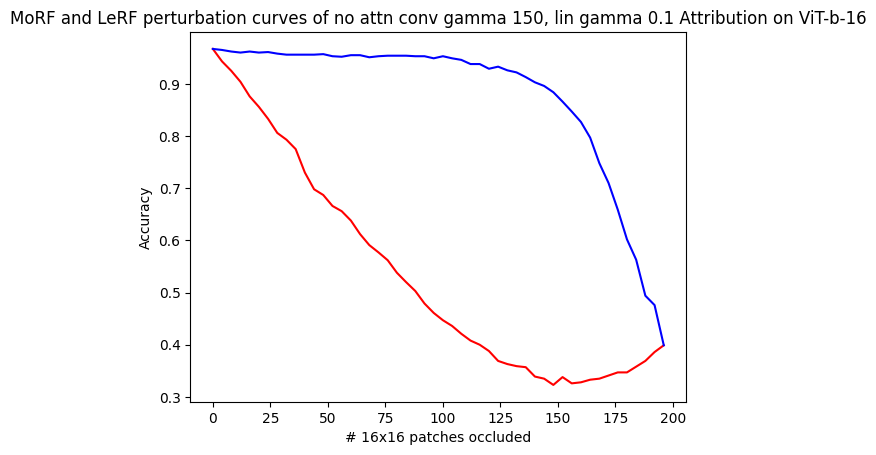

1.4026122448979594, 1.7402448979591836, 0.33763265306122414
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.31it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


1 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.37it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.86it/s]


3 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.61it/s]


4 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.52it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.50it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.47it/s]


7 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.51it/s]


8 [776, 224]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.89it/s]


9 [738, 262]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.75it/s]


10 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.68it/s]


11 [693, 307]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.54it/s]


12 [679, 321]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.30it/s]


13 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.39it/s]


14 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.28it/s]


15 [623, 377]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.84it/s]


16 [598, 402]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.85it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.96it/s]


18 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.60it/s]


19 [552, 448]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


20 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.49it/s]


21 [508, 492]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.66it/s]


22 [486, 514]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.89it/s]


23 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.71it/s]


24 [449, 551]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.03it/s]


25 [448, 552]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.30it/s]


26 [427, 573]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.29it/s]


27 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.44it/s]


28 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.52it/s]


29 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


30 [373, 627]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


31 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.58it/s]


32 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


33 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.79it/s]


34 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.23it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.94it/s]


36 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


37 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.18it/s]


38 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.34it/s]


39 [330, 670]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.11it/s]


40 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.21it/s]


41 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.47it/s]


42 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


43 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


44 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.53it/s]


45 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.44it/s]


46 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.48it/s]


0 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.76it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


2 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.59it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.83it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.55it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.74it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.91it/s]


7 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.08it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.99it/s]


9 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.74it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.87it/s]


11 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.91it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.65it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.24it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.43it/s]


16 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.17it/s]


17 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


18 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.94it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.32it/s]


20 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.11it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.39it/s]


22 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.00it/s]


23 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.60it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


25 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


26 [941, 59]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.39it/s]


27 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.02it/s]


28 [934, 66]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.97it/s]


29 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.34it/s]


30 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.08it/s]


31 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


32 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.84it/s]


33 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


34 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.39it/s]


35 [891, 109]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.59it/s]


36 [880, 120]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.00it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.11it/s]


38 [841, 159]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.44it/s]


39 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.32it/s]


40 [785, 215]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.07it/s]


41 [746, 254]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.47it/s]


42 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.17it/s]


43 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.82it/s]


44 [607, 393]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.94it/s]


45 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.36it/s]


46 [485, 515]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.50it/s]


47 [463, 537]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


48 [399, 601]


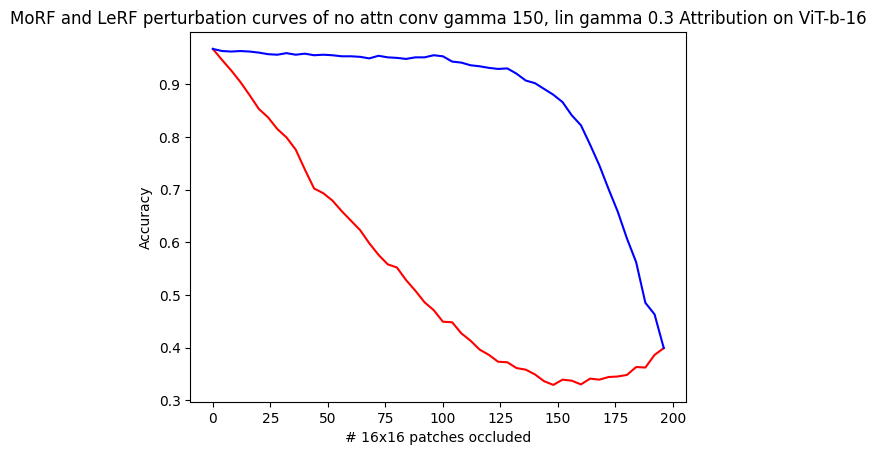

1.3782857142857143, 1.7242448979591836, 0.34595918367346934
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.91it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.97it/s]


1 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.53it/s]


2 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.04it/s]


3 [872, 128]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.12it/s]


4 [853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.95it/s]


5 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.20it/s]


6 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.36it/s]


7 [782, 218]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.38it/s]


8 [759, 241]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.62it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.93it/s]


10 [704, 296]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.93it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.58it/s]


12 [654, 346]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.44it/s]


13 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.15it/s]


14 [613, 387]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.07it/s]


15 [597, 403]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.39it/s]


16 [574, 426]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.41it/s]


17 [554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.60it/s]


18 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.53it/s]


19 [518, 482]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.99it/s]


20 [511, 489]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.12it/s]


21 [483, 517]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


22 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.86it/s]


23 [453, 547]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.78it/s]


24 [442, 558]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.85it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.27it/s]


26 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


27 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


28 [391, 609]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.90it/s]


29 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.41it/s]


30 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.10it/s]


31 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


32 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.09it/s]


33 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.87it/s]


35 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


36 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.23it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.83it/s]


38 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.56it/s]


39 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.00it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.23it/s]


41 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.88it/s]


42 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.80it/s]


43 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


44 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.00it/s]


45 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.49it/s]


46 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.12it/s]


47 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.86it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.92it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.25it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.97it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.06it/s]


4 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


5 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.90it/s]


8 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.75it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.19it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.45it/s]


12 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.97it/s]


13 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.71it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


18 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.56it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.40it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.17it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.83it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.26it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.41it/s]


26 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.22it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.56it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.12it/s]


29 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.52it/s]


30 [932, 68]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


31 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


32 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.59it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.76it/s]


34 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


35 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.74it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


37 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.08it/s]


38 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.10it/s]


39 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.42it/s]


40 [812, 188]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.12it/s]


41 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.77it/s]


42 [724, 276]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.95it/s]


43 [684, 316]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.39it/s]


44 [615, 385]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.09it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.42it/s]


46 [513, 487]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.41it/s]


47 [481, 519]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.08it/s]


48 [399, 601]


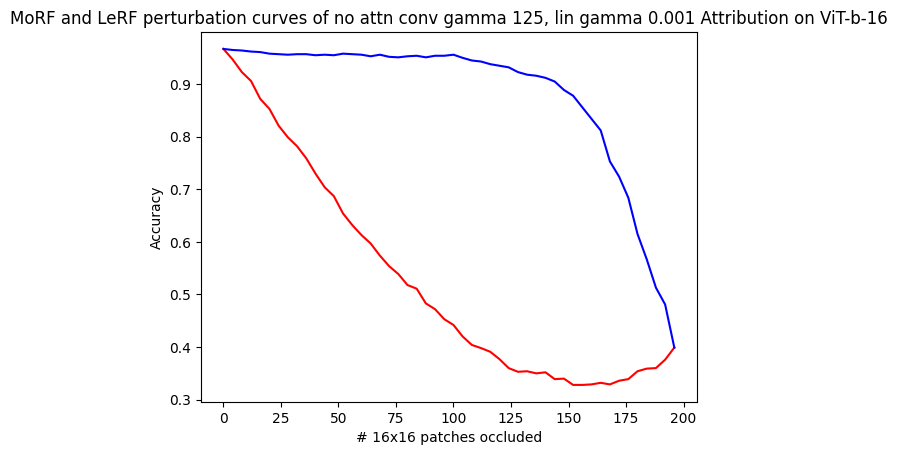

1.4447346938775507, 1.7687346938775508, 0.3240000000000001


In [21]:
for conv_gamma, mm_gamma in gamma_vals:
    attrs = torch.load(f"ourlrp_noattn_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")
    run_morf_lerf_occlusion(heatmaps=attrs, attr_name=f"no attn conv gamma {conv_gamma}, lin gamma {mm_gamma}", **default_args)

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.89it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.05it/s]


1 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.15it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.70it/s]


3 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.89it/s]


4 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.21it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.15it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.64it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.68it/s]


8 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.91it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.41it/s]


10 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.74it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.36it/s]


12 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.35it/s]


13 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.08it/s]


14 [638, 362]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


15 [612, 388]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.18it/s]


16 [591, 409]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.90it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.34it/s]


18 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.97it/s]


19 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.46it/s]


20 [520, 480]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.47it/s]


21 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


22 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.10it/s]


23 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.83it/s]


24 [446, 554]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.83it/s]


25 [436, 564]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.28it/s]


26 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


27 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.66it/s]


28 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.57it/s]


29 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.04it/s]


30 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.56it/s]


31 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.02it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.76it/s]


33 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.18it/s]


34 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.33it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.97it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.01it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


38 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.27it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.58it/s]


41 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.73it/s]


42 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.44it/s]


43 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.26it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.58it/s]


45 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.90it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.03it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.43it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.96it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.24it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.02it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.66it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.27it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.59it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.22it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.50it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.55it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


13 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


14 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.10it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.85it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.26it/s]


18 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.18it/s]


19 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.55it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.03it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.02it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.06it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.49it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.10it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.54it/s]


29 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.96it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.84it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.79it/s]


33 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.95it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.66it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.68it/s]


36 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.82it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.97it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.30it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.00it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.78it/s]


41 [749, 251]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.89it/s]


42 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.71it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.23it/s]


44 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.57it/s]


45 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


47 [476, 524]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]

48 [399, 601]


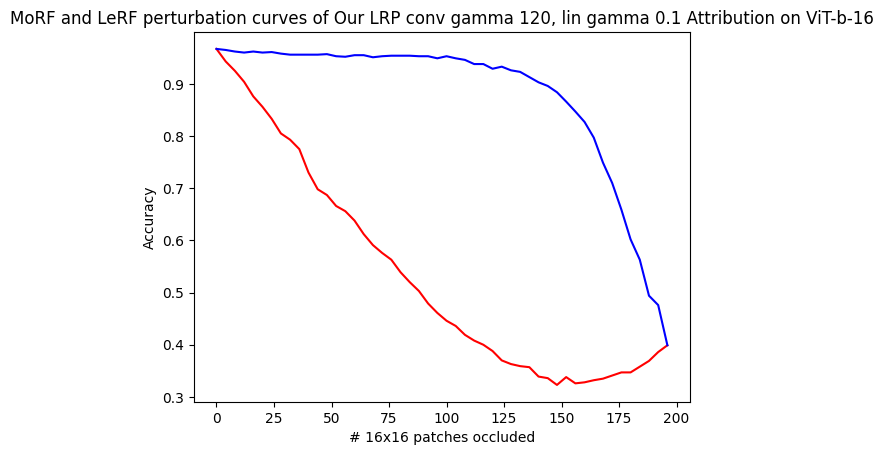

1.4029387755102047, 1.7404081632653061, 0.3374693877551015
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.95it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.27it/s]


1 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.44it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


3 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.91it/s]


4 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.31it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.49it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.74it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.82it/s]


8 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.56it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.61it/s]


10 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.12it/s]


12 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.71it/s]


13 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.42it/s]


14 [638, 362]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.53it/s]


15 [612, 388]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.36it/s]


16 [591, 409]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.39it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.28it/s]


18 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.36it/s]


19 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.45it/s]


20 [520, 480]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.59it/s]


21 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.55it/s]


22 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.66it/s]


23 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


24 [446, 554]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


25 [436, 564]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


26 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


27 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.60it/s]


28 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.44it/s]


29 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


30 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


31 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.31it/s]


33 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.83it/s]


34 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.36it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.28it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.33it/s]


38 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.00it/s]


40 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.59it/s]


41 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.31it/s]


42 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.50it/s]


43 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.86it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.47it/s]


45 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.68it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.32it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.83it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.63it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.47it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.45it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.72it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.40it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.47it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.12it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.95it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.20it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


13 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.97it/s]


14 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.25it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.02it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.59it/s]


18 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.08it/s]


19 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.99it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.72it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.64it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.69it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.95it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.08it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.34it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.88it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.90it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.52it/s]


29 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.18it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.94it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.67it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.69it/s]


33 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.45it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.30it/s]


36 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.97it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.95it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.98it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.98it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.31it/s]


41 [749, 251]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.10it/s]


42 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.07it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.05it/s]


44 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


45 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.06it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.89it/s]


47 [476, 524]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.03it/s]


48 [399, 601]


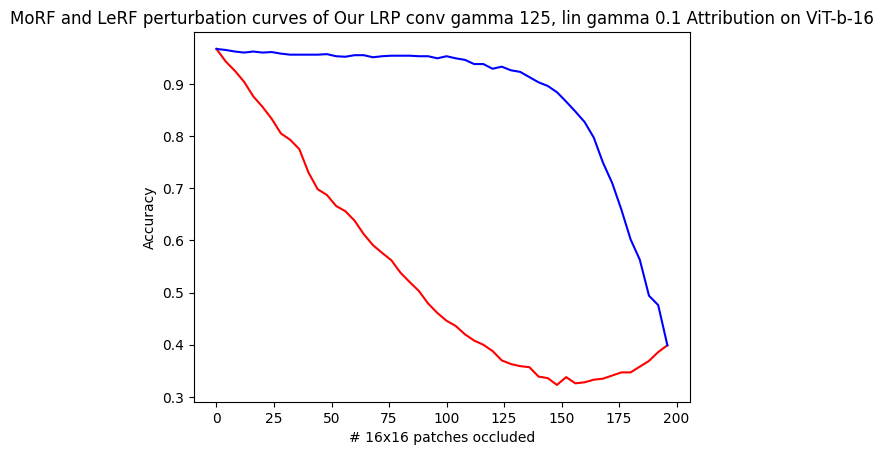

1.4029387755102047, 1.7404081632653061, 0.3374693877551015
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.06it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.00it/s]


1 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.77it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


3 [876, 124]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.25it/s]


4 [855, 145]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.78it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.03it/s]


6 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.68it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


8 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.26it/s]


10 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.12it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.56it/s]


12 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.59it/s]


13 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.46it/s]


14 [638, 362]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.70it/s]


15 [612, 388]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.33it/s]


16 [591, 409]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.83it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


18 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.41it/s]


19 [537, 463]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.47it/s]


20 [520, 480]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.72it/s]


21 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.35it/s]


22 [479, 521]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.30it/s]


23 [461, 539]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.62it/s]


24 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


25 [436, 564]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.72it/s]


26 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.56it/s]


27 [408, 592]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.71it/s]


28 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.96it/s]


29 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.29it/s]


30 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.75it/s]


31 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.85it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.12it/s]


33 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.17it/s]


34 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.36it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.84it/s]


36 [323, 677]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.19it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


38 [326, 674]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.17it/s]


39 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.51it/s]


40 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.02it/s]


41 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.30it/s]


42 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.54it/s]


43 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.08it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.41it/s]


45 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.51it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


47 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.46it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.53it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.23it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.06it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.91it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.99it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.12it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.62it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.09it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.85it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.16it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.50it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.81it/s]


13 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.36it/s]


14 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.43it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.94it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.21it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.66it/s]


18 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.16it/s]


19 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.00it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.35it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.63it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.83it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.22it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.86it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.17it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.80it/s]


29 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.80it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.83it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.59it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.23it/s]


33 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.10it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.32it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.17it/s]


36 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.83it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.16it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.72it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.78it/s]


41 [748, 252]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.13it/s]


42 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.19it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.46it/s]


44 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.88it/s]


45 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.98it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.27it/s]


47 [476, 524]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.18it/s]


48 [399, 601]


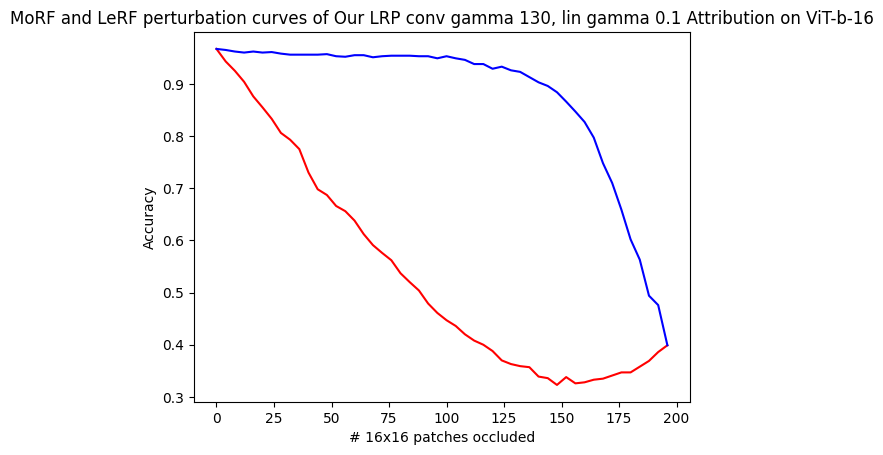

1.4027755102040822, 1.7403265306122448, 0.33755102040816254
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.88it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.54it/s]


1 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.94it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.85it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.78it/s]


4 [855, 145]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.01it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.23it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.85it/s]


8 [775, 225]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.24it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.68it/s]


11 [688, 312]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.96it/s]


12 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.62it/s]


13 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.71it/s]


14 [638, 362]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


15 [612, 388]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


16 [591, 409]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.32it/s]


17 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.26it/s]


18 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.90it/s]


19 [540, 460]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.02it/s]


20 [520, 480]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.59it/s]


21 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.30it/s]


22 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.74it/s]


23 [462, 538]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.13it/s]


24 [446, 554]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.65it/s]


25 [436, 564]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.62it/s]


26 [418, 582]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.81it/s]


27 [407, 593]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.63it/s]


28 [401, 599]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.82it/s]


29 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.06it/s]


30 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.77it/s]


31 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.01it/s]


32 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.81it/s]


33 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


34 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.96it/s]


35 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


36 [324, 676]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


37 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.04it/s]


39 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.64it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.51it/s]


41 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.19it/s]


42 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.01it/s]


43 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.23it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


45 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.56it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


47 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.99it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.32it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.17it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.76it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.39it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.54it/s]


5 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.27it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.69it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.95it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.83it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.70it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.65it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.23it/s]


13 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.62it/s]


14 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.35it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.37it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.88it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.51it/s]


18 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.36it/s]


19 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.60it/s]


20 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.70it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.15it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.19it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.34it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.44it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.53it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.46it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.44it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.82it/s]


29 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.74it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.97it/s]


31 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.39it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.34it/s]


33 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.25it/s]


34 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.41it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.93it/s]


36 [884, 116]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.79it/s]


37 [866, 134]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.48it/s]


39 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.49it/s]


41 [749, 251]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.53it/s]


42 [710, 290]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.20it/s]


43 [659, 341]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.63it/s]


44 [602, 398]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.46it/s]


45 [563, 437]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.00it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.63it/s]


47 [476, 524]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.73it/s]

48 [399, 601]


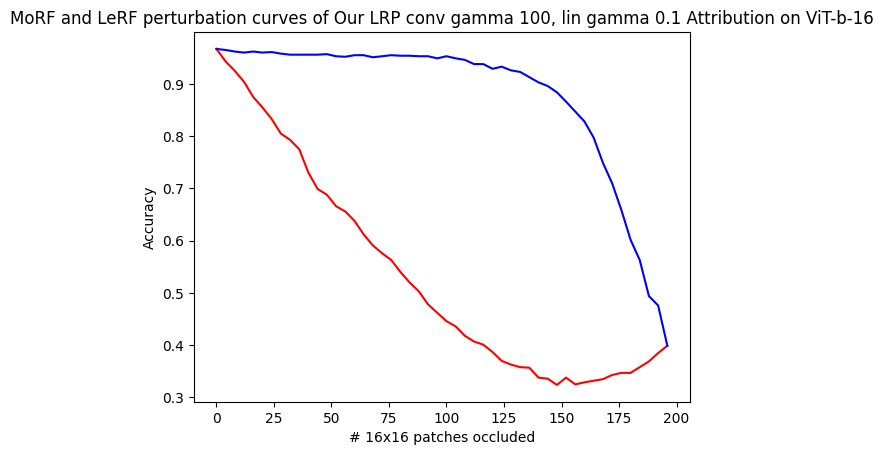

1.403183673469388, 1.740489795918367, 0.33730612244897884
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.23it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.55it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.54it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


3 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.20it/s]


5 [836, 164]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.22it/s]


6 [807, 193]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


7 [791, 209]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.12it/s]


8 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.55it/s]


9 [734, 266]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.63it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.89it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.68it/s]


12 [668, 332]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


13 [649, 351]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.92it/s]


14 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


15 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.62it/s]


16 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.94it/s]


17 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


18 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


19 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.99it/s]


20 [516, 484]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.56it/s]


21 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.40it/s]


22 [470, 530]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.19it/s]


23 [456, 544]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.11it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.38it/s]


25 [422, 578]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.81it/s]


26 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.91it/s]


27 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.26it/s]


28 [384, 616]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.95it/s]


29 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.28it/s]


30 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.97it/s]


31 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.21it/s]


32 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.67it/s]


33 [346, 654]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.69it/s]


34 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.76it/s]


35 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.59it/s]


36 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.59it/s]


37 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


38 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.54it/s]


39 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


40 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.66it/s]


41 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.12it/s]


42 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.12it/s]


43 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.64it/s]


44 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


45 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.68it/s]


46 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.79it/s]


47 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.80it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.87it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.80it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.95it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.51it/s]


5 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.99it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.14it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.18it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.58it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.82it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.71it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.45it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.71it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.47it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.82it/s]


16 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.57it/s]


17 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.17it/s]


18 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.02it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.87it/s]


20 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.17it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.94it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.94it/s]


23 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.42it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.81it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.75it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.48it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.20it/s]


29 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.70it/s]


30 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.88it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.40it/s]


32 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.55it/s]


33 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


34 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


35 [901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.29it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.38it/s]


37 [865, 135]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.58it/s]


38 [851, 149]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.45it/s]


39 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


40 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


41 [745, 255]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.35it/s]


42 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.20it/s]


43 [669, 331]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.09it/s]


45 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.09it/s]


46 [500, 500]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.84it/s]


47 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


48 [399, 601]


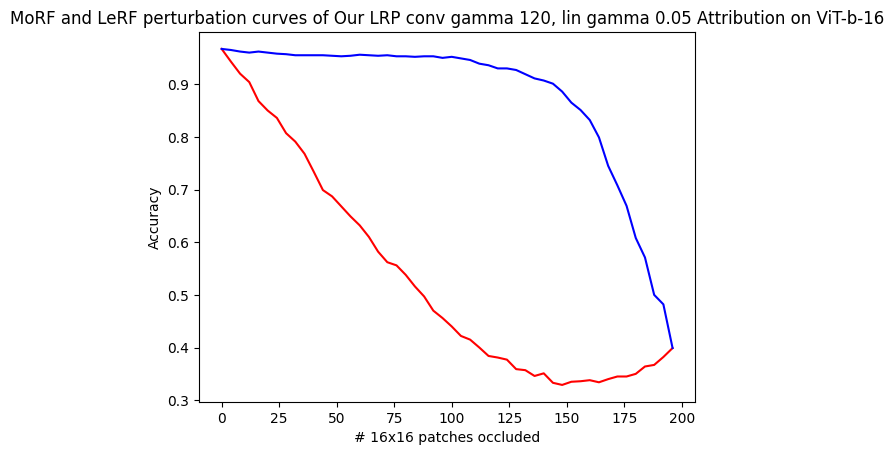

1.4146122448979594, 1.7491428571428569, 0.3345306122448973
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.91it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.13it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.81it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.60it/s]


3 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.65it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.17it/s]


5 [836, 164]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.28it/s]


6 [807, 193]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.83it/s]


7 [791, 209]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.46it/s]


8 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.19it/s]


9 [734, 266]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.43it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.55it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.35it/s]


12 [668, 332]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.31it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


14 [632, 368]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.74it/s]


15 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.86it/s]


16 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.19it/s]


17 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.49it/s]


18 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.33it/s]


19 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.90it/s]


20 [516, 484]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


21 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.61it/s]


22 [470, 530]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


23 [455, 545]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.47it/s]


25 [423, 577]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.61it/s]


26 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.46it/s]


27 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.60it/s]


28 [384, 616]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.38it/s]


29 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.25it/s]


30 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.46it/s]


31 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.10it/s]


32 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.72it/s]


33 [346, 654]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.05it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.47it/s]


35 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


36 [329, 671]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.25it/s]


37 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.86it/s]


38 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.76it/s]


39 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]


40 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.65it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.88it/s]


42 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.35it/s]


43 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.85it/s]


44 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.44it/s]


45 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.92it/s]


46 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.30it/s]


47 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.37it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.70it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.46it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.55it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.03it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.91it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.98it/s]


5 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.64it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.91it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.44it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.19it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.10it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.06it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.08it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.95it/s]


16 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.51it/s]


17 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.54it/s]


18 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.50it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.29it/s]


20 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.11it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.32it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.93it/s]


23 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.18it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.22it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.22it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.44it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.76it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.95it/s]


29 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


30 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.62it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.89it/s]


32 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.54it/s]


33 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


34 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.25it/s]


35 [901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


37 [865, 135]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.58it/s]


38 [851, 149]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.75it/s]


39 [831, 169]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.76it/s]


40 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.02it/s]


41 [745, 255]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.52it/s]


42 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.92it/s]


43 [669, 331]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.68it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.58it/s]


45 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.38it/s]


46 [500, 500]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.04it/s]


47 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


48 [399, 601]


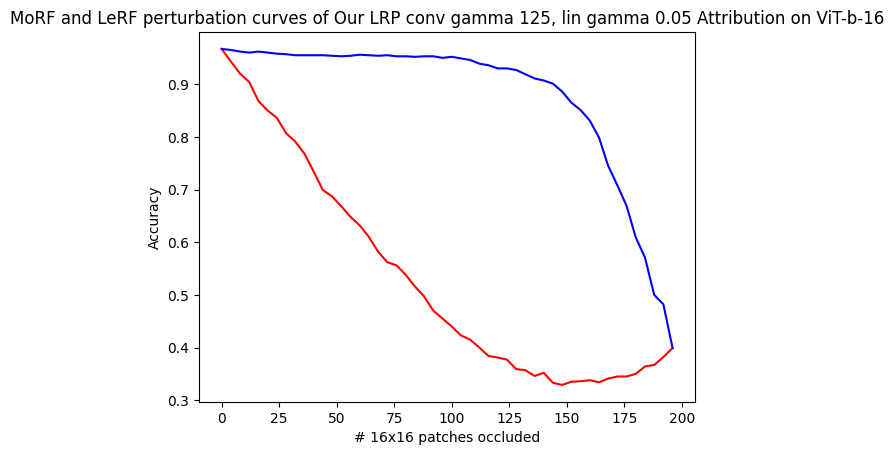

1.414530612244898, 1.7490612244897958, 0.3345306122448979
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.42it/s]


0 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.96it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.16it/s]


2 [904, 96]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.23it/s]


3 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.73it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


5 [836, 164]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.28it/s]


6 [807, 193]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.24it/s]


7 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.51it/s]


8 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.48it/s]


9 [734, 266]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.54it/s]


10 [699, 301]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.07it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


12 [668, 332]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.59it/s]


14 [634, 366]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


15 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.29it/s]


16 [582, 418]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.11it/s]


17 [561, 439]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.06it/s]


18 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.53it/s]


19 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.84it/s]


20 [516, 484]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


21 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.02it/s]


22 [470, 530]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.75it/s]


23 [454, 546]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.55it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.97it/s]


25 [423, 577]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.11it/s]


26 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.88it/s]


27 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.40it/s]


28 [384, 616]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.21it/s]


29 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.65it/s]


30 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


31 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.25it/s]


32 [357, 643]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.46it/s]


33 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.43it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.34it/s]


35 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.57it/s]


36 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.36it/s]


37 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.07it/s]


38 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.67it/s]


39 [338, 662]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.31it/s]


40 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


42 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


43 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


44 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.45it/s]


45 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.62it/s]


46 [367, 633]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.82it/s]


47 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.36it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.65it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.01it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.09it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.15it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.44it/s]


5 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.64it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.06it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.32it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.97it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.92it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.89it/s]


11 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.07it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.09it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.15it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.60it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.57it/s]


16 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.15it/s]


17 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.46it/s]


18 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


19 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


20 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.28it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.13it/s]


22 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.47it/s]


23 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.32it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.07it/s]


26 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.68it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.10it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


29 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.58it/s]


30 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.95it/s]


32 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.76it/s]


33 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.51it/s]


34 [907, 93]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.19it/s]


35 [901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


37 [865, 135]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.08it/s]


38 [851, 149]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.95it/s]


39 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


40 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.50it/s]


41 [744, 256]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.15it/s]


42 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


43 [669, 331]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.46it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.80it/s]


45 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.32it/s]


46 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.83it/s]


47 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.99it/s]


48 [399, 601]


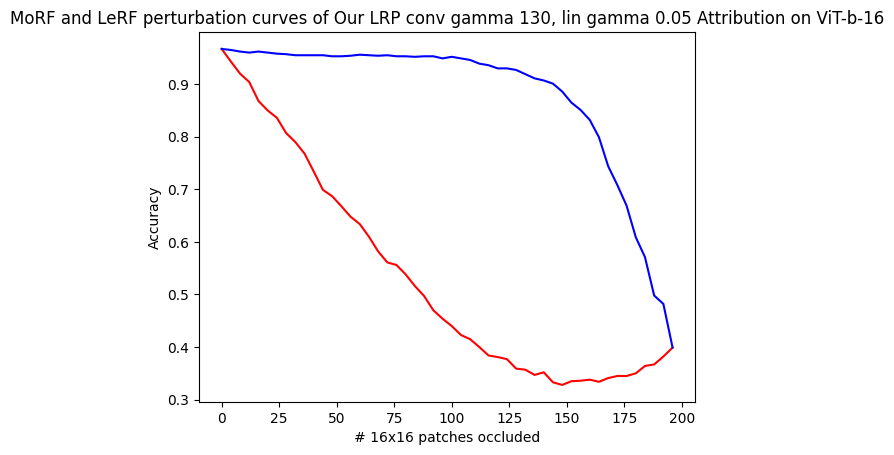

1.4142857142857141, 1.7491428571428569, 0.3348571428571426
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.01it/s]


2 [903, 97]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


3 [870, 130]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.40it/s]


4 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.15it/s]


5 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


6 [806, 194]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.12it/s]


7 [781, 219]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.95it/s]


8 [755, 245]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.77it/s]


9 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.86it/s]


10 [706, 294]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.63it/s]


11 [677, 323]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.52it/s]


12 [658, 342]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


13 [636, 364]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.28it/s]


14 [619, 381]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.45it/s]


15 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.31it/s]


16 [579, 421]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.24it/s]


17 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.40it/s]


18 [538, 462]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.24it/s]


19 [521, 479]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.38it/s]


20 [506, 494]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.65it/s]


21 [486, 514]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


22 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.61it/s]


23 [452, 548]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


24 [434, 566]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.51it/s]


26 [404, 596]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


27 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.62it/s]


28 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.66it/s]


29 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.16it/s]


30 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


31 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.13it/s]


32 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.44it/s]


33 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.33it/s]


34 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.42it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


36 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.79it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


38 [325, 675]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.91it/s]


39 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


40 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


41 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.35it/s]


42 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.48it/s]


43 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.54it/s]


44 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.30it/s]


45 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.39it/s]


46 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


47 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.65it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.75it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.28it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.38it/s]


2 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.77it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.39it/s]


4 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.57it/s]


5 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.51it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.03it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.05it/s]


8 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.96it/s]


10 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.72it/s]


11 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


12 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.98it/s]


14 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.45it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.10it/s]


16 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.58it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.99it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.69it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


21 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.63it/s]


22 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.96it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.14it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.32it/s]


26 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.27it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.91it/s]


28 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.35it/s]


29 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.88it/s]


30 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.18it/s]


31 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.71it/s]


32 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.84it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.42it/s]


34 [912, 88]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.06it/s]


35 [906, 94]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


36 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.93it/s]


37 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.70it/s]


39 [830, 170]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.93it/s]


40 [811, 189]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.75it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.28it/s]


42 [719, 281]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.52it/s]


43 [679, 321]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


44 [616, 384]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.67it/s]


45 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


46 [501, 499]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.13it/s]


47 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.15it/s]


48 [399, 601]


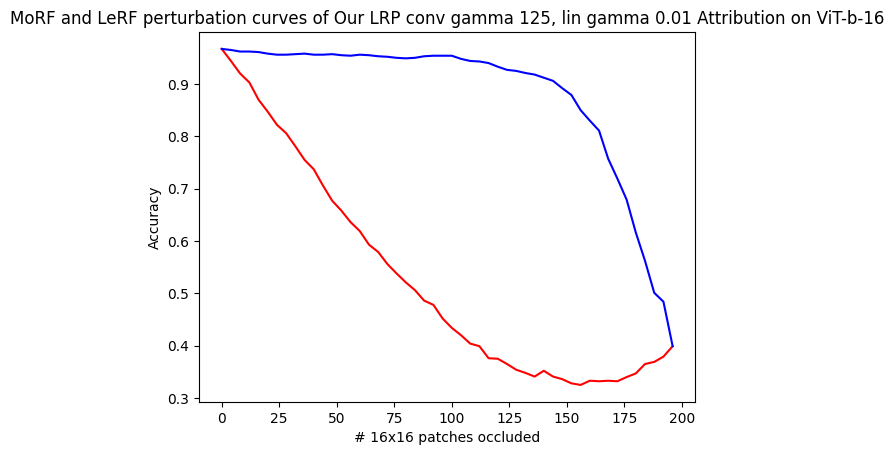

1.442612244897959, 1.769959183673469, 0.32734693877551


In [19]:
for conv_gamma, mm_gamma in gamma_vals:
    attrs = torch.load(f"ourlrp_noattn_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")
    run_morf_lerf_occlusion(heatmaps=attrs, attr_name=f"no attn conv gamma {conv_gamma}, lin gamma {mm_gamma}", **default_args)

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.51it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.06it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.63it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.73it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.39it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.48it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.75it/s]


7 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.69it/s]


8 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.25it/s]


10 [705, 295]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


11 [692, 308]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.13it/s]


12 [665, 335]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.97it/s]


13 [647, 353]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.79it/s]


14 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.24it/s]


15 [598, 402]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.71it/s]


16 [569, 431]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.49it/s]


17 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.07it/s]


18 [547, 453]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


19 [523, 477]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


20 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.63it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.33it/s]


22 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.80it/s]


23 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


24 [441, 559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


25 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.83it/s]


26 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.18it/s]


27 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.77it/s]


28 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.29it/s]


29 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.67it/s]


31 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.50it/s]


32 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.66it/s]


33 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


34 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.78it/s]


35 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.80it/s]


37 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.48it/s]


38 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.66it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.36it/s]


40 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


41 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.51it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.57it/s]


43 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.80it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


45 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.53it/s]


46 [380, 620]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.74it/s]


47 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.58it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.46it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.09it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.14it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.39it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.88it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.62it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.68it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.45it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.58it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.85it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.45it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.64it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.91it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.02it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.49it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.27it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.07it/s]


20 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.89it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.53it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.02it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.73it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.96it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.81it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.14it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.40it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.21it/s]


29 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.46it/s]


30 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.03it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.08it/s]


32 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.77it/s]


33 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.47it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.78it/s]


35 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.99it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.63it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.71it/s]


38 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


39 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.92it/s]


40 [795, 205]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.11it/s]


41 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.49it/s]


42 [713, 287]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


43 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.89it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.40it/s]


45 [559, 441]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.07it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.89it/s]


47 [474, 526]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.29it/s]


48 [399, 601]


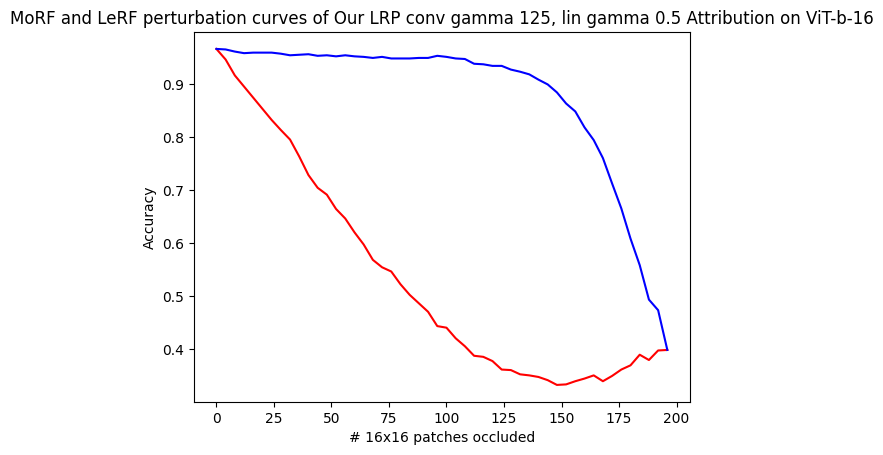

1.4122448979591835, 1.7484081632653061, 0.3361632653061226
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.37it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.20it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.34it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.59it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.66it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.02it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.17it/s]


7 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.15it/s]


8 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.57it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.89it/s]


10 [705, 295]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.99it/s]


11 [692, 308]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.64it/s]


12 [665, 335]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.52it/s]


13 [647, 353]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.18it/s]


14 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.96it/s]


15 [598, 402]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.57it/s]


16 [570, 430]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.68it/s]


17 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.76it/s]


18 [547, 453]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.47it/s]


19 [523, 477]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


20 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.17it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.83it/s]


22 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


23 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.13it/s]


24 [441, 559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.70it/s]


25 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


26 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.61it/s]


27 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.05it/s]


28 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.64it/s]


29 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.43it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.05it/s]


31 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.28it/s]


32 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.87it/s]


33 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.38it/s]


34 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.03it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.94it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.72it/s]


37 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.86it/s]


38 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.32it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.49it/s]


40 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.48it/s]


41 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.39it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.30it/s]


43 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.00it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.95it/s]


45 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.33it/s]


46 [380, 620]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.25it/s]


47 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.18it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.95it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.14it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.55it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.25it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.46it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.09it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.48it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.65it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.30it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.44it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.08it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.73it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.05it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.53it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.42it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.72it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.56it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.11it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.05it/s]


20 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.17it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.83it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.27it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.74it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.23it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.59it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.40it/s]


29 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.83it/s]


30 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.77it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.42it/s]


32 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.32it/s]


33 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.36it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.98it/s]


35 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.63it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.38it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.18it/s]


38 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


39 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.01it/s]


40 [795, 205]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.54it/s]


41 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.14it/s]


42 [713, 287]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.60it/s]


43 [666, 334]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.75it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.19it/s]


45 [559, 441]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.00it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.64it/s]


47 [474, 526]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.44it/s]


48 [399, 601]


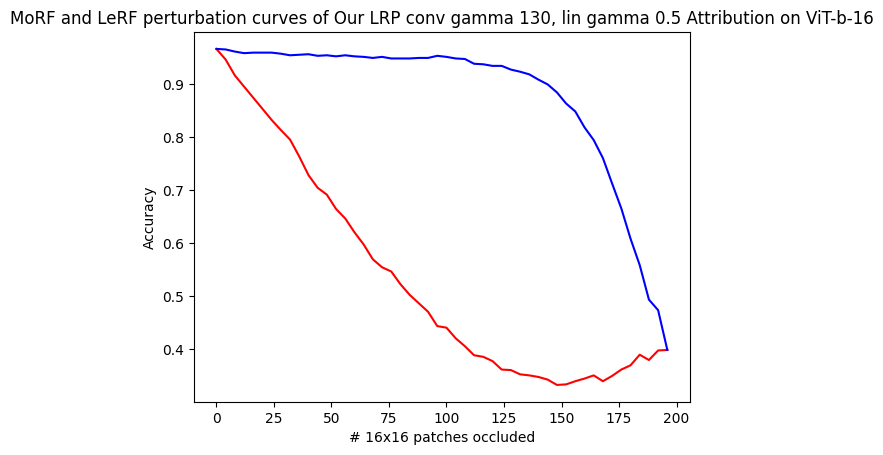

1.4119999999999997, 1.7481632653061223, 0.3361632653061226
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.61it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.15it/s]


2 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.20it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.28it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.63it/s]


5 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


6 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.75it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.15it/s]


8 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.73it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.81it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.98it/s]


11 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.27it/s]


12 [655, 345]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.92it/s]


13 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.77it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.12it/s]


15 [599, 401]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.51it/s]


16 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.41it/s]


17 [561, 439]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.56it/s]


18 [548, 452]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.58it/s]


19 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.68it/s]


20 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.25it/s]


21 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


22 [467, 533]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.53it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.53it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.59it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.18it/s]


26 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]


27 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.21it/s]


28 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.79it/s]


29 [374, 626]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.79it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.73it/s]


31 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.01it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.59it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.78it/s]


34 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.42it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.00it/s]


36 [332, 668]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.54it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.71it/s]


38 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.11it/s]


39 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.26it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.33it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.50it/s]


42 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.42it/s]


43 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.67it/s]


44 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.04it/s]


45 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.10it/s]


46 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


47 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.89it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.28it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.02it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.50it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.63it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.78it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.38it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.96it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.17it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.71it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.21it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.79it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.98it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.87it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.97it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.05it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.97it/s]


17 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.41it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.58it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.96it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.68it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.97it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.05it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


25 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.54it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.49it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.00it/s]


28 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.86it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.37it/s]


30 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.30it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.53it/s]


32 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.30it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.06it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.41it/s]


35 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.77it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


37 [869, 131]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.15it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.32it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


40 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


41 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.90it/s]


42 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.55it/s]


43 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.26it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.10it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.20it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.74it/s]


47 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.90it/s]

48 [399, 601]


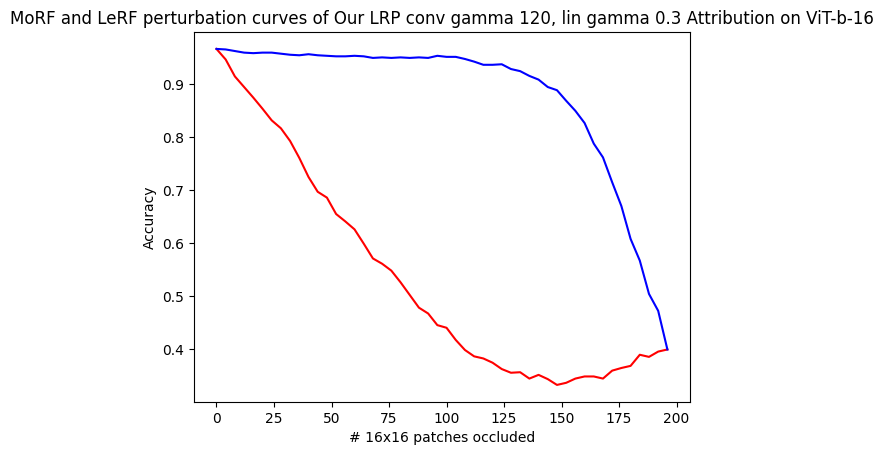

1.419510204081633, 1.7521632653061223, 0.33265306122448945
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.79it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.68it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.68it/s]


2 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.67it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.71it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.24it/s]


5 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


6 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.92it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.26it/s]


8 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.68it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.64it/s]


11 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.57it/s]


12 [655, 345]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.50it/s]


13 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.77it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.01it/s]


15 [599, 401]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.19it/s]


16 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.84it/s]


17 [561, 439]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.23it/s]


18 [548, 452]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.52it/s]


19 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.10it/s]


20 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.54it/s]


21 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.28it/s]


22 [467, 533]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.77it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.06it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.57it/s]


26 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.16it/s]


27 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.04it/s]


28 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.57it/s]


29 [374, 626]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.69it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.20it/s]


31 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.51it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.50it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.38it/s]


34 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.70it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.52it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.60it/s]


38 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.94it/s]


39 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.72it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.47it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.36it/s]


42 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.63it/s]


43 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.41it/s]


44 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.22it/s]


45 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


46 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


47 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.15it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.30it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.08it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.53it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.50it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.98it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.13it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.47it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.72it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.56it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.44it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.20it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.20it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.72it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.12it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.06it/s]


17 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.90it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.60it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.30it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.08it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.35it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.00it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.30it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.37it/s]


25 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.08it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.23it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.05it/s]


28 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.79it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


30 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.39it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.54it/s]


32 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.52it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.97it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


35 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.26it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.92it/s]


37 [869, 131]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.20it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.27it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


40 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.07it/s]


41 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.51it/s]


42 [716, 284]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.60it/s]


43 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.28it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.58it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.25it/s]


47 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.13it/s]


48 [399, 601]


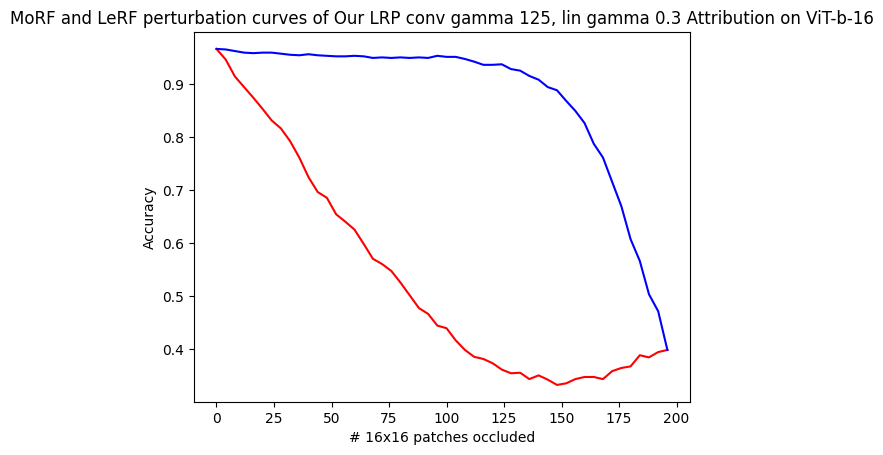

1.41934693877551, 1.7518367346938772, 0.33248979591836736
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.36it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.53it/s]


1 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.17it/s]


2 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.18it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.35it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.92it/s]


5 [832, 168]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.99it/s]


6 [817, 183]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.15it/s]


8 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.59it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.39it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


11 [686, 314]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.87it/s]


12 [655, 345]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.13it/s]


13 [641, 359]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


15 [599, 401]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.66it/s]


16 [571, 429]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.53it/s]


17 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.48it/s]


18 [548, 452]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


19 [526, 474]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.18it/s]


20 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.51it/s]


21 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.27it/s]


22 [467, 533]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.08it/s]


23 [445, 555]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.39it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


25 [417, 583]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.79it/s]


26 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.18it/s]


27 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.74it/s]


28 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.32it/s]


29 [374, 626]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.31it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.82it/s]


31 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.96it/s]


33 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.51it/s]


34 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.63it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.46it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.13it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


38 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.62it/s]


39 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


40 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.13it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.71it/s]


42 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.03it/s]


43 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


44 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.61it/s]


45 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


46 [385, 615]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.65it/s]


47 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.58it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.18it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.97it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.54it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.30it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.98it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.71it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.25it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.55it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.32it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.31it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.35it/s]


10 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.63it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.42it/s]


13 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.44it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.10it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.80it/s]


17 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.18it/s]


18 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.87it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.28it/s]


20 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.66it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.78it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.74it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.78it/s]


25 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.22it/s]


27 [943, 57]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.47it/s]


28 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.82it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.58it/s]


30 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.53it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.18it/s]


32 [926, 74]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.98it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.70it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.35it/s]


35 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.83it/s]


36 [889, 111]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


37 [869, 131]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.52it/s]


38 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.62it/s]


39 [827, 173]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.77it/s]


40 [788, 212]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.23it/s]


41 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.70it/s]


42 [716, 284]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.34it/s]


43 [670, 330]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.05it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.67it/s]


45 [567, 433]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.23it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.57it/s]


47 [472, 528]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


48 [399, 601]


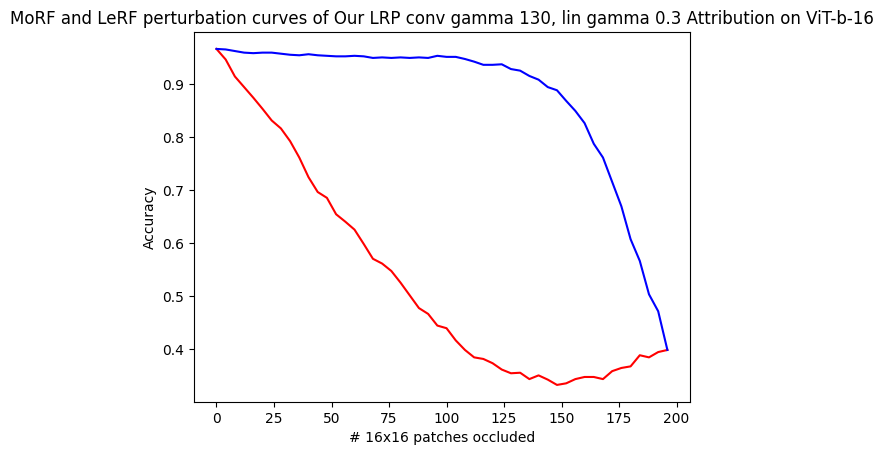

1.4193469387755098, 1.751836734693877, 0.33248979591836736
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.10it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.24it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.60it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.90it/s]


3 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.49it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.15it/s]


5 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.30it/s]


7 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.55it/s]


8 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.08it/s]


9 [726, 274]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.51it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.01it/s]


11 [673, 327]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.83it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.92it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.89it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.67it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.72it/s]


16 [573, 427]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.94it/s]


17 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.06it/s]


18 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.51it/s]


19 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.80it/s]


20 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


21 [483, 517]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.30it/s]


22 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.03it/s]


23 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.87it/s]


24 [429, 571]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.46it/s]


25 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.36it/s]


26 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.53it/s]


27 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.21it/s]


28 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.98it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.13it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.02it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.10it/s]


32 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.56it/s]


33 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.40it/s]


34 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.12it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.98it/s]


36 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.55it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.62it/s]


38 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.70it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.20it/s]


40 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.47it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


42 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.25it/s]


43 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.58it/s]


44 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.32it/s]


45 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.53it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.40it/s]


47 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.83it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.75it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.58it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.11it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.10it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.86it/s]


5 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.34it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.54it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.08it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.53it/s]


10 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.40it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.73it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.66it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.81it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.76it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.07it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.06it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.30it/s]


18 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.92it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.92it/s]


20 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.11it/s]


21 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.66it/s]


22 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.78it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.68it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.07it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


26 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.88it/s]


27 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.97it/s]


28 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.19it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.52it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.04it/s]


32 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.33it/s]


34 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.77it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.68it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.20it/s]


37 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.17it/s]


38 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.11it/s]


39 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.25it/s]


40 [794, 206]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.30it/s]


42 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.89it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.10it/s]


44 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.22it/s]


45 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.05it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.76it/s]


47 [477, 523]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


48 [399, 601]


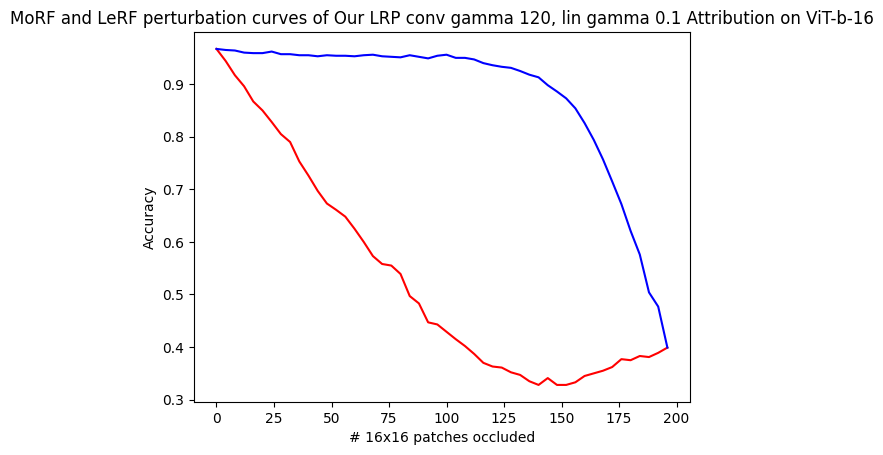

1.4351020408163269, 1.7623673469387755, 0.3272653061224484
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.94it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.83it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.07it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.54it/s]


3 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.30it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.54it/s]


5 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.15it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.60it/s]


7 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


8 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.65it/s]


11 [673, 327]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.99it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.61it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.18it/s]


16 [573, 427]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.95it/s]


17 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.77it/s]


18 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.53it/s]


19 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.54it/s]


20 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.60it/s]


21 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.34it/s]


22 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.06it/s]


23 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.61it/s]


24 [429, 571]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.46it/s]


25 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


26 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.86it/s]


27 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.55it/s]


28 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.57it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.07it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.25it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.65it/s]


32 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.45it/s]


33 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.58it/s]


34 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.29it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.49it/s]


36 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.09it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.94it/s]


38 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.49it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.90it/s]


40 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.96it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.77it/s]


42 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.18it/s]


43 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


44 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.21it/s]


45 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.09it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.03it/s]


47 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.86it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.72it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.86it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.86it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.62it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.67it/s]


5 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.07it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.73it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.72it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.58it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.95it/s]


10 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.03it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.65it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.70it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.29it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.88it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.07it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.48it/s]


18 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.61it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.28it/s]


20 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.16it/s]


21 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


22 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.91it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.82it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.23it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.88it/s]


26 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


27 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


28 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.68it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.49it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.43it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.99it/s]


32 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.80it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.00it/s]


34 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.22it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.18it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.01it/s]


37 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.22it/s]


38 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.48it/s]


39 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.85it/s]


40 [794, 206]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.16it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.84it/s]


42 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.84it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


44 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.10it/s]


45 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.24it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.65it/s]


47 [477, 523]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.63it/s]


48 [399, 601]


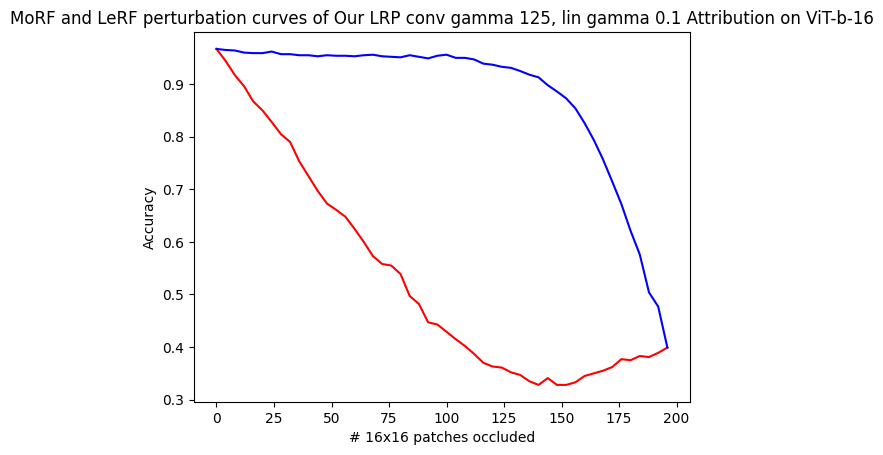

1.4352653061224496, 1.7625306122448974, 0.32726530612244786
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.28it/s]


0 [944, 56]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.09it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.97it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.85it/s]


3 [867, 133]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.87it/s]


4 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.81it/s]


5 [828, 172]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.73it/s]


6 [805, 195]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.05it/s]


7 [790, 210]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.34it/s]


8 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.47it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.11it/s]


10 [697, 303]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


11 [673, 327]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.26it/s]


12 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.71it/s]


13 [648, 352]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.99it/s]


15 [600, 400]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.63it/s]


16 [573, 427]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


17 [558, 442]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.36it/s]


18 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.38it/s]


19 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.88it/s]


20 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.74it/s]


21 [482, 518]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


22 [447, 553]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.07it/s]


23 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.85it/s]


24 [429, 571]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.43it/s]


25 [415, 585]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


26 [402, 598]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.07it/s]


27 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.11it/s]


28 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.01it/s]


29 [363, 637]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.38it/s]


30 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.35it/s]


31 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.33it/s]


32 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.14it/s]


33 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.45it/s]


34 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


35 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.23it/s]


36 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.58it/s]


37 [328, 672]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


38 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.16it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.58it/s]


40 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.92it/s]


41 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.68it/s]


42 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.25it/s]


43 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.65it/s]


44 [375, 625]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.00it/s]


45 [383, 617]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.49it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.60it/s]


47 [389, 611]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.77it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.29it/s]


0 [965, 35]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.89it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.19it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.60it/s]


3 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.87it/s]


4 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.77it/s]


5 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.35it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.46it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.33it/s]


9 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


10 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.75it/s]


12 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


13 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.45it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.58it/s]


15 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.63it/s]


16 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


17 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.05it/s]


18 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


20 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.91it/s]


21 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.00it/s]


22 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.03it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.88it/s]


24 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.54it/s]


25 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.08it/s]


26 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.96it/s]


27 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.77it/s]


28 [940, 60]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.11it/s]


29 [937, 63]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.01it/s]


30 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.27it/s]


31 [931, 69]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.70it/s]


32 [925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.37it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.68it/s]


34 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.59it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.58it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


37 [873, 127]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.23it/s]


38 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.51it/s]


39 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.53it/s]


40 [794, 206]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.52it/s]


42 [715, 285]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.14it/s]


43 [672, 328]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.10it/s]


44 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.79it/s]


45 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.21it/s]


46 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.05it/s]


47 [477, 523]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.13it/s]


48 [399, 601]


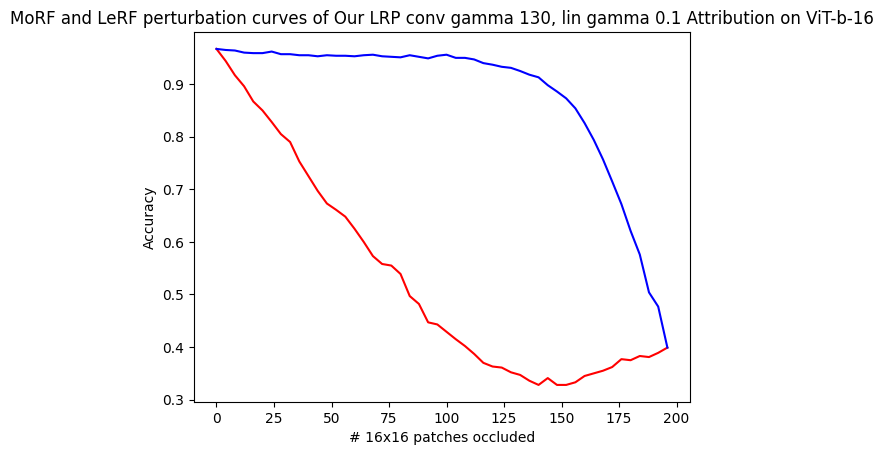

1.435265306122449, 1.7624489795918363, 0.32718367346938737
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.18it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.71it/s]


1 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.13it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.06it/s]


3 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.87it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.67it/s]


5 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.54it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.69it/s]


7 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


8 [765, 235]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.11it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.39it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.78it/s]


11 [691, 309]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.15it/s]


12 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


13 [646, 354]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.86it/s]


14 [629, 371]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.63it/s]


15 [596, 404]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.34it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.64it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


18 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.75it/s]


19 [525, 475]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.20it/s]


20 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.05it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


23 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.30it/s]


24 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.66it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.17it/s]


27 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.38it/s]


28 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.56it/s]


29 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


30 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.08it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.26it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


33 [346, 654]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.34it/s]


34 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.46it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.40it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.67it/s]


38 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.02it/s]


40 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.10it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.36it/s]


42 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.11it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.17it/s]


44 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.77it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.91it/s]


46 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.19it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.98it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.03it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.01it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.68it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.65it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.26it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.39it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.58it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.29it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.76it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.94it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.23it/s]


12 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.99it/s]


13 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.07it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.33it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.01it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.13it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.21it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.08it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.68it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.62it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.41it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.79it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.95it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.87it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.34it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.40it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.44it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.54it/s]


34 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.02it/s]


35 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.34it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.40it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.86it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.71it/s]


39 [823, 177]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.89it/s]


40 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.92it/s]


42 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.88it/s]


43 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.95it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


45 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.24it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.43it/s]


47 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.63it/s]


48 [399, 601]


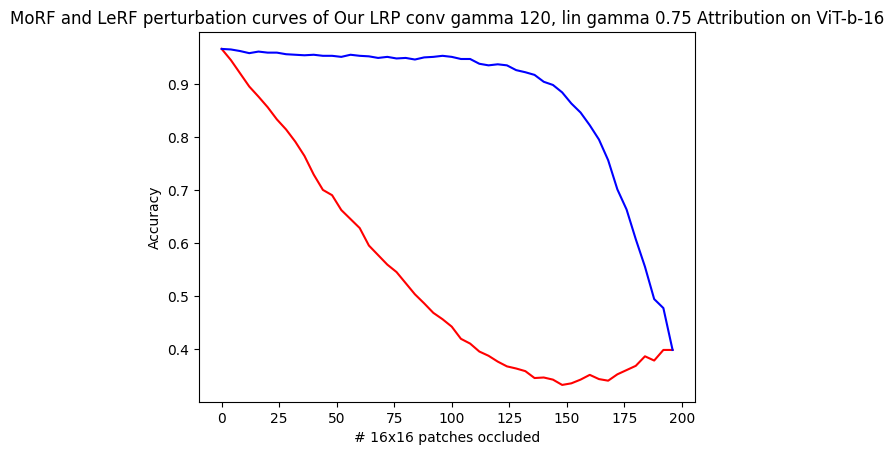

1.4058775510204082, 1.7433469387755098, 0.3374693877551015
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.18it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.47it/s]


1 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.99it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.35it/s]


3 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.66it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


5 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.56it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.24it/s]


7 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


8 [765, 235]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.19it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.32it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.41it/s]


11 [691, 309]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.02it/s]


12 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.13it/s]


13 [646, 354]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.71it/s]


14 [629, 371]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.42it/s]


15 [596, 404]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.87it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.89it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.97it/s]


18 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.84it/s]


19 [525, 475]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.66it/s]


20 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.75it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.96it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.88it/s]


23 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]


24 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.21it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.66it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.73it/s]


27 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.94it/s]


28 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


29 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.85it/s]


30 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


32 [359, 641]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.45it/s]


33 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.80it/s]


34 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.27it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.98it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.87it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.61it/s]


38 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.28it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


40 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.31it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.26it/s]


42 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.06it/s]


44 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.55it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.57it/s]


46 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.57it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.32it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.63it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.50it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.80it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.40it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.08it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.50it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.57it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.62it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.43it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.92it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.91it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.85it/s]


12 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.83it/s]


13 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.38it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.11it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.18it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.08it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.34it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.06it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.78it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.32it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.78it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.77it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.44it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.86it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.28it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.56it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.00it/s]


34 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


35 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.01it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.13it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.29it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.39it/s]


39 [823, 177]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.39it/s]


40 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.69it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.65it/s]


42 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]


43 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.84it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.92it/s]


45 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.91it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.75it/s]


47 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.20it/s]

48 [399, 601]


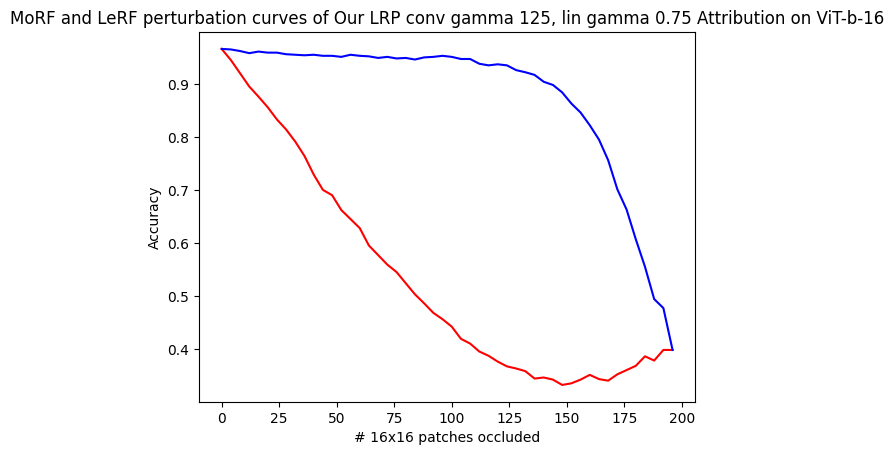

1.4059591836734693, 1.7434285714285709, 0.3374693877551015
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.18it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.39it/s]


1 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.75it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.99it/s]


3 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.31it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.28it/s]


5 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.54it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.60it/s]


7 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.25it/s]


8 [765, 235]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.34it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.13it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.57it/s]


11 [691, 309]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.62it/s]


12 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.23it/s]


13 [646, 354]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.19it/s]


14 [628, 372]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.58it/s]


15 [596, 404]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.34it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.62it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.36it/s]


18 [546, 454]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.46it/s]


19 [525, 475]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.68it/s]


20 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.34it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.83it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.26it/s]


23 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.11it/s]


24 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.17it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.64it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.38it/s]


27 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.89it/s]


28 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.00it/s]


29 [377, 623]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.60it/s]


30 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.10it/s]


32 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.10it/s]


33 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.99it/s]


34 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.44it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.59it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.41it/s]


37 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.86it/s]


38 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.17it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.26it/s]


40 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


42 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.57it/s]


44 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.16it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.59it/s]


46 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.32it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.96it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.07it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.39it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.87it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.76it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.70it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.61it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.08it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.49it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.53it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.68it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.15it/s]


12 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.28it/s]


13 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.96it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.95it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.95it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.81it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.96it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.37it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.06it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.71it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.96it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.34it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.92it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.37it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.06it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.65it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.79it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.32it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.82it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.72it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.41it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


34 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.04it/s]


35 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.64it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.02it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.41it/s]


38 [848, 152]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.78it/s]


39 [823, 177]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.03it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.82it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.24it/s]


42 [702, 298]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


43 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.86it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.42it/s]


45 [557, 443]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.67it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.69it/s]


47 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.96it/s]

48 [399, 601]


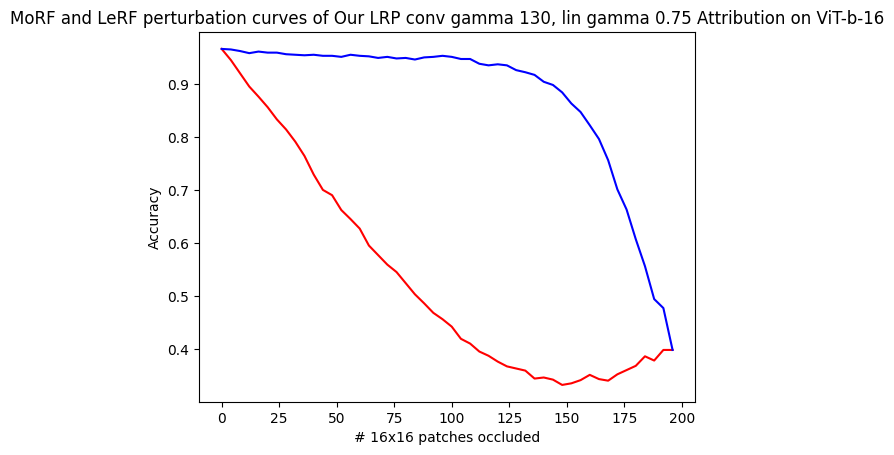

1.4062857142857144, 1.7435102040816322, 0.3372244897959178


In [17]:
for conv_gamma, mm_gamma in gamma_vals:
    attrs = torch.load(f"ourlrp_noattn_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")
    run_morf_lerf_occlusion(heatmaps=attrs, attr_name=f"Our LRP conv gamma {conv_gamma}, lin gamma {mm_gamma}", **default_args)

Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.09it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.08it/s]


1 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.30it/s]


2 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.45it/s]


3 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.40it/s]


4 [859, 141]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.91it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.70it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.38it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.38it/s]


8 [763, 237]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.70it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.57it/s]


10 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.13it/s]


11 [689, 311]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.27it/s]


12 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.66it/s]


13 [650, 350]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.35it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.56it/s]


15 [595, 405]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.01it/s]


16 [579, 421]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.06it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.26it/s]


18 [545, 455]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.45it/s]


19 [527, 473]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.66it/s]


20 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.26it/s]


21 [484, 516]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.81it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.11it/s]


23 [456, 544]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.95it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.05it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.87it/s]


26 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.57it/s]


27 [394, 606]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.45it/s]


28 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.23it/s]


29 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.86it/s]


30 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.00it/s]


31 [365, 635]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.37it/s]


32 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


33 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.82it/s]


34 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.48it/s]


35 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.49it/s]


36 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.48it/s]


37 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.36it/s]


38 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.90it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.01it/s]


40 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.12it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.92it/s]


42 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.23it/s]


44 [373, 627]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.51it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.71it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.85it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.74it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.95it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.13it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.90it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.45it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.07it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.15it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.43it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.86it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.49it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.58it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.26it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.30it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.21it/s]


14 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.75it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.77it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.64it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.30it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.51it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.19it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.82it/s]


23 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.24it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.61it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.96it/s]


26 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.73it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.39it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.99it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.54it/s]


32 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.58it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.80it/s]


35 [897, 103]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.74it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.37it/s]


37 [861, 139]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.25it/s]


38 [845, 155]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.97it/s]


39 [824, 176]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.10it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.56it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.26it/s]


42 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.79it/s]


43 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.84it/s]


45 [553, 447]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.70it/s]


46 [496, 504]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.33it/s]


47 [475, 525]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.38it/s]


48 [399, 601]


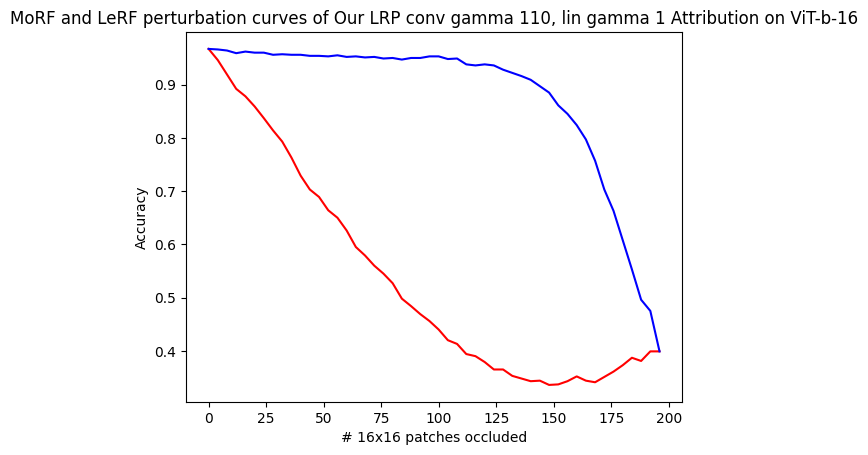

1.4058775510204071, 1.7441632653061219, 0.33828571428571474
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.92it/s]


0 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.93it/s]


1 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.41it/s]


2 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.91it/s]


3 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.29it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.15it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.01it/s]


6 [812, 188]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.30it/s]


7 [793, 207]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.79it/s]


8 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.07it/s]


9 [725, 275]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.82it/s]


10 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.73it/s]


11 [687, 313]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.52it/s]


12 [662, 338]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.58it/s]


13 [652, 348]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.78it/s]


14 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.03it/s]


15 [595, 405]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.70it/s]


16 [580, 420]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.44it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.87it/s]


18 [539, 461]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.23it/s]


19 [531, 469]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.04it/s]


20 [500, 500]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.95it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.15it/s]


22 [467, 533]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.10it/s]


23 [459, 541]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.80it/s]


24 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.06it/s]


25 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.65it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.99it/s]


27 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.00it/s]


28 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.89it/s]


29 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.81it/s]


30 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.03it/s]


31 [358, 642]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.35it/s]


32 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.96it/s]


33 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.83it/s]


34 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.88it/s]


35 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.21it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


37 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.92it/s]


38 [339, 661]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.62it/s]


39 [346, 654]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.01it/s]


40 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.47it/s]


41 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.08it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.42it/s]


43 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.39it/s]


44 [372, 628]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.79it/s]


45 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.67it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.20it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.08it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.64it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.83it/s]


2 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.05it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.11it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.49it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.80it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.31it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.18it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.97it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.68it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.73it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.07it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.07it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.80it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.66it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


16 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.75it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.70it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.71it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.66it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.19it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.74it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.91it/s]


23 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


24 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


25 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.41it/s]


26 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.70it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.42it/s]


28 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.06it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.80it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


31 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.93it/s]


32 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.55it/s]


33 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.95it/s]


34 [908, 92]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.14it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.68it/s]


36 [882, 118]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.41it/s]


37 [860, 140]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.96it/s]


38 [845, 155]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.24it/s]


39 [821, 179]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.74it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


41 [754, 246]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.00it/s]


42 [707, 293]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.85it/s]


43 [662, 338]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.41it/s]


44 [603, 397]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


45 [550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


46 [498, 502]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.85it/s]


47 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


48 [399, 601]


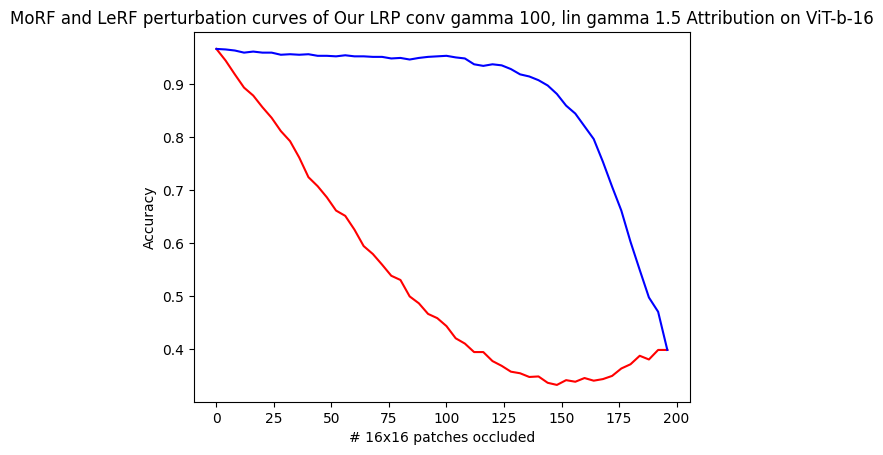

1.4048979591836734, 1.7440816326530608, 0.33918367346938727
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.70it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.05it/s]


1 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.41it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.98it/s]


3 [877, 123]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.05it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


5 [834, 166]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.72it/s]


7 [791, 209]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.89it/s]


8 [766, 234]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.92it/s]


9 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.15it/s]


10 [701, 299]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.86it/s]


11 [691, 309]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.83it/s]


12 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]


13 [646, 354]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.35it/s]


14 [629, 371]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.82it/s]


15 [596, 404]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.35it/s]


16 [576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.34it/s]


17 [559, 441]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.85it/s]


18 [545, 455]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.11it/s]


19 [525, 475]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.87it/s]


20 [504, 496]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.86it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.71it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.48it/s]


23 [457, 543]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.25it/s]


24 [442, 558]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.06it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.24it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.18it/s]


27 [396, 604]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.02it/s]


28 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.77it/s]


29 [376, 624]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.60it/s]


30 [368, 632]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.82it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.80it/s]


32 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.74it/s]


33 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.86it/s]


34 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.99it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.06it/s]


36 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.03it/s]


37 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.54it/s]


38 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.46it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.53it/s]


40 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.57it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.21it/s]


42 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.46it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.73it/s]


44 [369, 631]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.10it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.32it/s]


46 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.10it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.02it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.56it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.38it/s]


1 [963, 37]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.65it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.23it/s]


3 [961, 39]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.51it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.20it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.13it/s]


6 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.34it/s]


7 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.08it/s]


8 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.57it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.13it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.47it/s]


12 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.23it/s]


13 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.62it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.94it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.26it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.73it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.34it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.05it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.29it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.37it/s]


21 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.79it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.38it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.10it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.96it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.72it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.69it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.16it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.14it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.64it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.08it/s]


33 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


34 [905, 95]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.51it/s]


35 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.29it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.60it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.53it/s]


38 [847, 153]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.65it/s]


39 [823, 177]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.88it/s]


40 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.38it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.94it/s]


42 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.42it/s]


43 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.14it/s]


44 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.50it/s]


45 [556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.01it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.10it/s]


47 [478, 522]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.19it/s]


48 [399, 601]


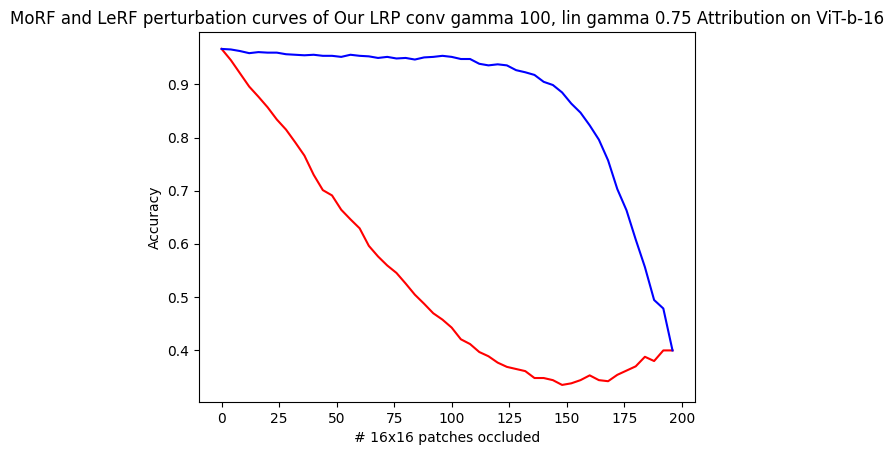

1.405877551020408, 1.7435102040816322, 0.33763265306122414
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.07it/s]


0 [945, 55]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.14it/s]


1 [920, 80]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.56it/s]


2 [894, 106]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.21it/s]


3 [879, 121]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.29it/s]


4 [859, 141]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.61it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.44it/s]


7 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.79it/s]


8 [762, 238]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.64it/s]


9 [727, 273]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.62it/s]


10 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.42it/s]


11 [690, 310]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.18it/s]


12 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.68it/s]


13 [651, 349]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.03it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


15 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.01it/s]


16 [579, 421]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.46it/s]


17 [562, 438]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.68it/s]


18 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.11it/s]


19 [527, 473]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.30it/s]


20 [502, 498]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.77it/s]


21 [486, 514]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.19it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.72it/s]


23 [460, 540]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.04it/s]


24 [443, 557]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.59it/s]


25 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


26 [411, 589]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.70it/s]


27 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


28 [395, 605]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.88it/s]


29 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.66it/s]


30 [366, 634]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.08it/s]


31 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.99it/s]


32 [355, 645]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


33 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.30it/s]


34 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.03it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.88it/s]


36 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


37 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.28it/s]


38 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.65it/s]


39 [347, 653]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.98it/s]


40 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.07it/s]


41 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.89it/s]


43 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.68it/s]


44 [371, 629]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.61it/s]


45 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.37it/s]


46 [382, 618]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.35it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.65it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.29it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.47it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.05it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.96it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.76it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.61it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.67it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.05it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.59it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.20it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.50it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.41it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.00it/s]


14 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.45it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.09it/s]


16 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.49it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.52it/s]


19 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.02it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.81it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.44it/s]


22 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.75it/s]


23 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.07it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.61it/s]


25 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.49it/s]


26 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


28 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.81it/s]


29 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.13it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.04it/s]


31 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.48it/s]


32 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.98it/s]


33 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.12it/s]


34 [910, 90]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.13it/s]


35 [899, 101]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.40it/s]


36 [883, 117]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.27it/s]


37 [861, 139]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.29it/s]


38 [846, 154]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.40it/s]


39 [824, 176]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.08it/s]


40 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.06it/s]


41 [753, 247]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.38it/s]


42 [708, 292]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.71it/s]


43 [663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


44 [610, 390]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.47it/s]


45 [550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


46 [496, 504]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.59it/s]


47 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.64it/s]


48 [399, 601]


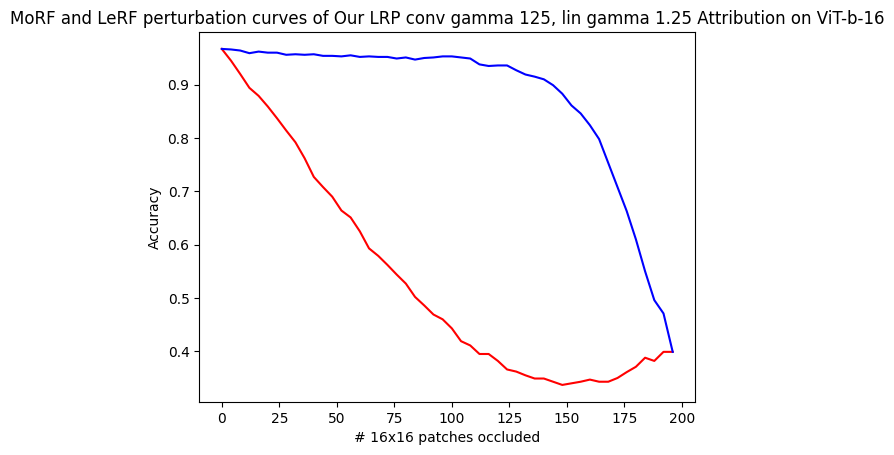

1.4034285714285715, 1.7418775510204076, 0.33844897959183623
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.43it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.10it/s]


1 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.49it/s]


2 [892, 108]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.64it/s]


3 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.63it/s]


4 [859, 141]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.98it/s]


5 [837, 163]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.99it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.33it/s]


7 [794, 206]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.34it/s]


8 [763, 237]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.08it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


10 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.67it/s]


11 [689, 311]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.35it/s]


12 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.25it/s]


13 [650, 350]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.65it/s]


14 [625, 375]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.39it/s]


15 [595, 405]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


16 [578, 422]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.80it/s]


17 [559, 441]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.12it/s]


18 [545, 455]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.68it/s]


19 [528, 472]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.19it/s]


20 [497, 503]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.22it/s]


21 [483, 517]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.40it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.13it/s]


23 [456, 544]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


24 [439, 561]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.02it/s]


25 [420, 580]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.52it/s]


26 [413, 587]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.59it/s]


27 [394, 606]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.65it/s]


28 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.41it/s]


29 [379, 621]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.90it/s]


30 [365, 635]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.13it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.61it/s]


32 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.03it/s]


33 [349, 651]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


34 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.22it/s]


35 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.60it/s]


36 [336, 664]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.80it/s]


37 [337, 663]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.93it/s]


38 [344, 656]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.57it/s]


39 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.47it/s]


40 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.78it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.42it/s]


42 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.42it/s]


43 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.26it/s]


44 [373, 627]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.67it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.86it/s]


46 [381, 619]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.41it/s]


47 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.33it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.18it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.84it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.87it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.09it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.79it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.87it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.48it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.26it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.65it/s]


14 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.56it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.18it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.32it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.01it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.67it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.45it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.91it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.77it/s]


23 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.30it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.92it/s]


25 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.09it/s]


26 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.11it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.73it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.32it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.32it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.97it/s]


32 [922, 78]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.83it/s]


33 [916, 84]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.16it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.16it/s]


35 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.63it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.57it/s]


37 [861, 139]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.62it/s]


38 [845, 155]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.26it/s]


39 [824, 176]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.78it/s]


40 [797, 203]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.11it/s]


41 [757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.90it/s]


42 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


43 [662, 338]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.93it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.76it/s]


45 [553, 447]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.33it/s]


46 [495, 505]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.84it/s]


47 [475, 525]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.16it/s]


48 [399, 601]


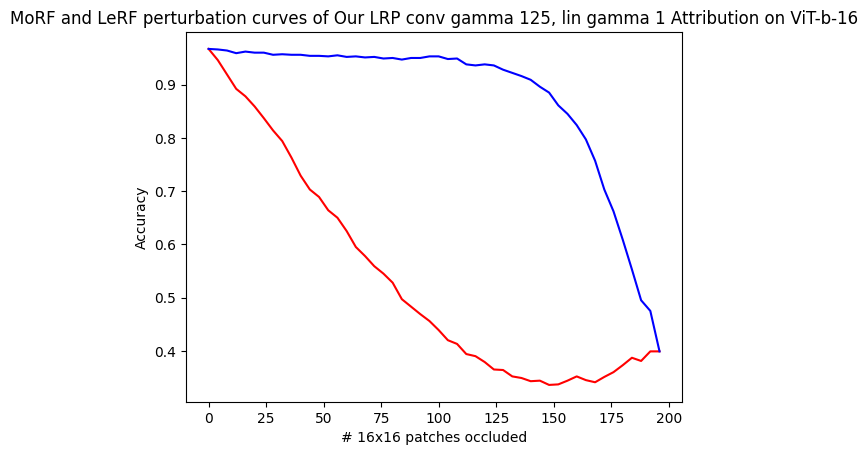

1.4060408163265303, 1.7444897959183672, 0.3384489795918368
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.93it/s]


0 [946, 54]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.41it/s]


1 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.18it/s]


2 [895, 105]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.84it/s]


3 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.36it/s]


4 [857, 143]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.85it/s]


5 [835, 165]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.70it/s]


6 [815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.80it/s]


7 [792, 208]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.21it/s]


8 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.83it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


10 [704, 296]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.42it/s]


11 [690, 310]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.33it/s]


12 [664, 336]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.62it/s]


13 [646, 354]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.87it/s]


14 [628, 372]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.52it/s]


15 [593, 407]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.84it/s]


16 [577, 423]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.78it/s]


17 [560, 440]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.58it/s]


18 [544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.34it/s]


19 [530, 470]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.90it/s]


20 [501, 499]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.43it/s]


21 [485, 515]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.18it/s]


22 [469, 531]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.98it/s]


23 [458, 542]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.93it/s]


24 [440, 560]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.30it/s]


25 [419, 581]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.33it/s]


26 [412, 588]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.63it/s]


27 [394, 606]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.27it/s]


28 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.88it/s]


29 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.35it/s]


30 [366, 634]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.96it/s]


31 [364, 636]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.39it/s]


32 [356, 644]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


33 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.69it/s]


34 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.68it/s]


35 [343, 657]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.01it/s]


36 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.18it/s]


37 [335, 665]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.79it/s]


38 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.81it/s]


39 [354, 646]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.24it/s]


40 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.24it/s]


41 [341, 659]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.13it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.97it/s]


43 [360, 640]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.76it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.80it/s]


45 [387, 613]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.39it/s]


46 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.21it/s]


47 [400, 600]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.96it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.80it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.03it/s]


1 [964, 36]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.01it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.22it/s]


3 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.38it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.00it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.23it/s]


6 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.69it/s]


7 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.49it/s]


9 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.22it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.33it/s]


11 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.07it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.26it/s]


13 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.54it/s]


14 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.22it/s]


15 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.75it/s]


16 [951, 49]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.75it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.71it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.71it/s]


19 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.42it/s]


20 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.05it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.00it/s]


22 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.35it/s]


23 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.15it/s]


24 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.16it/s]


25 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.97it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.93it/s]


27 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.21it/s]


28 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.59it/s]


29 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.69it/s]


30 [936, 64]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.44it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.88it/s]


32 [923, 77]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.94it/s]


33 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.97it/s]


34 [908, 92]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.73it/s]


35 [898, 102]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.03it/s]


36 [885, 115]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.75it/s]


37 [863, 137]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.29it/s]


38 [846, 154]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.37it/s]


39 [822, 178]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.88it/s]


40 [799, 201]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.89it/s]


41 [758, 242]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.64it/s]


42 [703, 297]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.12it/s]


43 [661, 339]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.49it/s]


44 [607, 393]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.08it/s]


45 [554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.93it/s]


46 [496, 504]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.46it/s]


47 [475, 525]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.26it/s]


48 [399, 601]


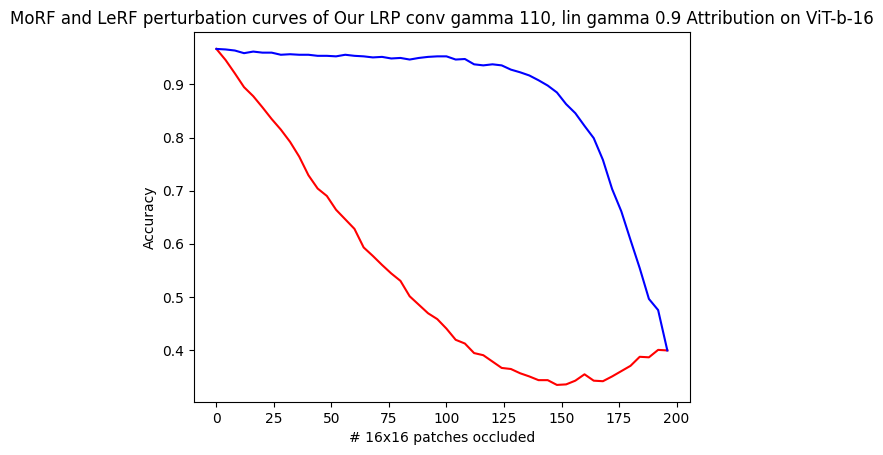

1.406204081632653, 1.7439183673469387, 0.33771428571428574
Running 49 occlusion iterations with 16x16 patches
Baseline correct/incorrect ratio is [967, 33]
Generating blurred images


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.78it/s]


0 [947, 53]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.64it/s]


1 [917, 83]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.46it/s]


2 [896, 104]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.40it/s]


3 [875, 125]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.33it/s]


4 [854, 146]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.27it/s]


5 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.33it/s]


6 [814, 186]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.77it/s]


7 [796, 204]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.24it/s]


8 [764, 236]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.92it/s]


9 [729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.85it/s]


10 [705, 295]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.78it/s]


11 [691, 309]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.44it/s]


12 [665, 335]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.99it/s]


13 [647, 353]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.72it/s]


14 [621, 379]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.08it/s]


15 [598, 402]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.43it/s]


16 [570, 430]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.66it/s]


17 [555, 445]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.58it/s]


18 [547, 453]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.88it/s]


19 [523, 477]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.50it/s]


20 [503, 497]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.50it/s]


21 [487, 513]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.43it/s]


22 [471, 529]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.58it/s]


23 [444, 556]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.91it/s]


24 [441, 559]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.78it/s]


25 [421, 579]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.53it/s]


26 [406, 594]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.92it/s]


27 [388, 612]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.71it/s]


28 [386, 614]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.48it/s]


29 [378, 622]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.60it/s]


30 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.10it/s]


31 [361, 639]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.90it/s]


32 [353, 647]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.88it/s]


33 [352, 648]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.27it/s]


34 [348, 652]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.06it/s]


35 [342, 658]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.60it/s]


36 [333, 667]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.26it/s]


37 [334, 666]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.00it/s]


38 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.91it/s]


39 [345, 655]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.51it/s]


40 [351, 649]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.26it/s]


41 [340, 660]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.63it/s]


42 [350, 650]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.54it/s]


43 [362, 638]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.05it/s]


44 [370, 630]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.08it/s]


45 [390, 610]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.79it/s]


46 [380, 620]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.28it/s]


47 [398, 602]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.96it/s]


48 [399, 601]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.04it/s]


0 [966, 34]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.14it/s]


1 [962, 38]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.25it/s]


2 [959, 41]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.50it/s]


3 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.73it/s]


4 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.65it/s]


5 [960, 40]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.49it/s]


6 [958, 42]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.01it/s]


7 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.58it/s]


8 [956, 44]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.70it/s]


9 [957, 43]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.93it/s]


10 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.20it/s]


11 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.89it/s]


12 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.84it/s]


13 [955, 45]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.91it/s]


14 [953, 47]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.21it/s]


15 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.48it/s]


16 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.68it/s]


17 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.27it/s]


18 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.97it/s]


19 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.05it/s]


20 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


21 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.54it/s]


22 [950, 50]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.03it/s]


23 [954, 46]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.54it/s]


24 [952, 48]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.74it/s]


25 [949, 51]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.20it/s]


26 [948, 52]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.50it/s]


27 [939, 61]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


28 [938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.19it/s]


29 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.30it/s]


30 [935, 65]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.28it/s]


31 [928, 72]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.98it/s]


32 [924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.20it/s]


33 [919, 81]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.54it/s]


34 [909, 91]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.85it/s]


35 [900, 100]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.34it/s]


36 [886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.73it/s]


37 [864, 136]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.93it/s]


38 [849, 151]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.37it/s]


39 [819, 181]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


40 [795, 205]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.45it/s]


41 [761, 239]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.91it/s]


42 [713, 287]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.10it/s]


43 [667, 333]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.63it/s]


44 [609, 391]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.25it/s]


45 [559, 441]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.44it/s]


46 [494, 506]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.59it/s]


47 [474, 526]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.98it/s]


48 [399, 601]


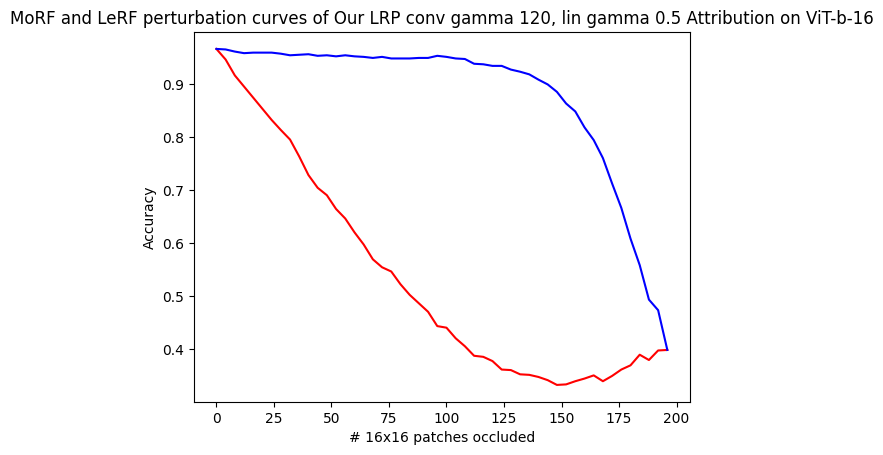

1.412326530612245, 1.7483265306122444, 0.3359999999999994


In [18]:
for conv_gamma, mm_gamma in gamma_vals:
    attrs = torch.load(f"ourlrp_gamma_conv{conv_gamma}_lin{mm_gamma}.pt")
    run_morf_lerf_occlusion(heatmaps=attrs, attr_name=f"Our LRP conv gamma {conv_gamma}, lin gamma {mm_gamma}", **default_args)

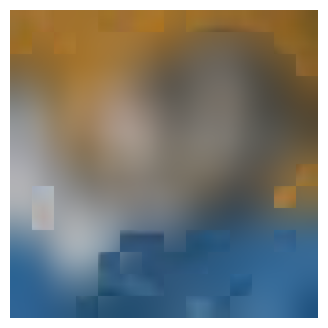

In [34]:
plot_img(morf_imgs_list[0])

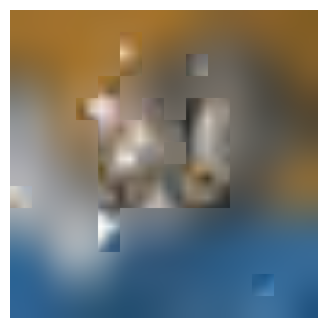

In [35]:
plot_img(lerf_imgs_list[0])

# The below is from AttnLRP attributions for comparison

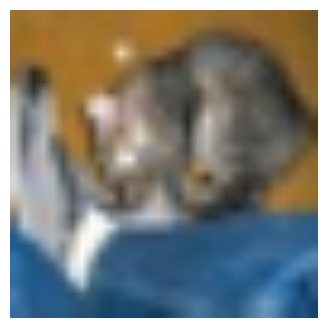

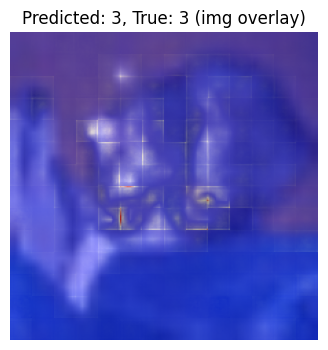

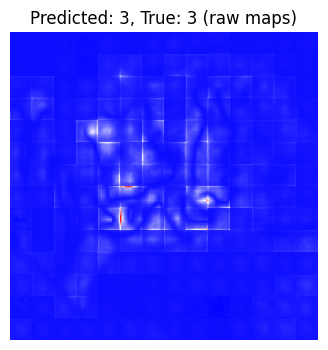

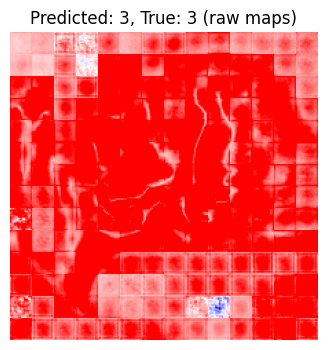

In [25]:
img_ind = 0
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
pred_idx = true_label
hmap = attnlrp_attrs[img_ind]
total_heatmap = hmap.squeeze(0).squeeze(0)
# total_heatmap = hmap[0][0] + hmap[0][1] + hmap[0][2]
pos_mask = total_heatmap < 0
clamped_heatmap = total_heatmap.clamp(min=total_heatmap.quantile(0.0), max=total_heatmap.quantile(0.5))
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)
visualize_attributions(img_tensor.squeeze(0).detach(), clamped_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)

In [11]:
promises = list(lrp_engine.promise_bucket.start_nodes_to_promise.keys())
len(promises)

76